In [43]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import numpy as np

In [2]:
df = pd.read_csv('train-2.csv')

In [3]:
print('number of rows: ', df.shape[0])
print('number of columns: ', df.shape[1])

number of rows:  42000
number of columns:  785


In [38]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [8]:
data = df.as_matrix()

In [13]:
X, y = data[:,1:], data[:,0]

In [17]:
# scale X to be 0 to 1
X = X/225.0

### PCA - dimension reduction

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

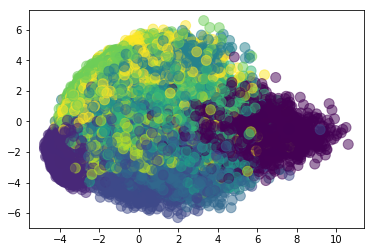

In [25]:
pca = PCA(n_components  = 2)
reduced = pca.fit_transform(X)
plt.scatter(reduced[:,0], reduced[:,1], s = 100, c = y, alpha = 0.5)
plt.show()

After reducing the dimension from 784D to 2D, i am able to plot it in a chart. Interestingsly, there are several category are far apart in this 2D chart. I am going to reduce dimension before putting into model.

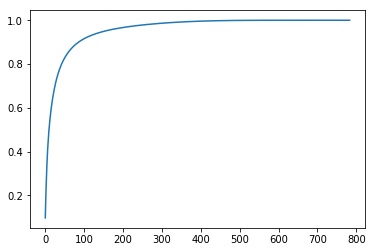

In [29]:
pca = PCA()
reduced = pca.fit_transform(X)

cumulative = []
last = 0
for v in pca.explained_variance_ratio_:
    cumulative.append(last + v)
    last = cumulative[-1]
    
plt.plot(cumulative)
plt.show()

I am going to keep 100 dimension first and keep adding dimension to see if any improvement in the final score

### Benchmark Model - Logistic Regression

In [35]:
data = shuffle(data)
X, y = data[:,1:], data[:,0]
cutoff = 0.8
Xtrain, ytrain = X[:int(0.8*len(data))], y[:int(0.8*len(data))]
Xtest, ytest = X[int(0.8*len(data)):], y[int(0.8*len(data)):]
print('number of samples in train set is ', len(Xtrain))
print('number of samples in test set is ', len(Xtest))

number of samples in train set is  33600
number of samples in test set is  8400


In [36]:
# decided to keep 300 components
pca = PCA(n_components  = 300)
Ztrain = pca.fit_transform(Xtrain)
Ztest = pca.transform(Xtest)

In [37]:
lr = LogisticRegression()
lr.fit(Ztrain, ytrain)
print('Train set score is ', lr.score(Ztrain, ytrain))
print('Test set score is ', lr.score(Ztest, ytest))

Train set score is  0.927172619048
Test set score is  0.919047619048


### Neural Network

In [49]:
# first step is to convert the label column into indicator matrix
K = len(set(y))
def y2indicator(y, K):
    result = np.zeros((len(y), K))
    for i in range(len(y)):
        result[i, y[i]] = 1
    return result

In [81]:
ytrain_ind = y2indicator(ytrain, K)
ytest_ind = y2indicator(ytest, K)

In [52]:
# forward propagation
def forward(X, W1, b1, W2, b2):
    """
    Input:
        X - Input matrix
        W1 - first layer weights
        b1 - first layer bias term
        W2 - second layer weights
        b2 - second layer bias term
    output - probability of Y = 1 given X
    """
    Z = 1 / (1 + np.exp(-X.dot(W1) - b1))
    A = Z.dot(W2) + b2
    expA = np.exp(A)
    Y = expA / expA.sum(axis = 1, keepdims = True)
    return Y, Z

In [53]:
def predict(p_y):
    return np.argmax(p_y, axis = 1)

In [54]:
# back propagation

def derivative_w2(Z, T, Y):
    return Z.T.dot(T - Y)

def derivative_b2(T, Y):
    return np.sum(T-Y, axis = 0)

def derivative_w1(X, Z, T, Y, W2):
    return X.T.dot((T-Y).dot(W2.T) * Z * (1-Z))

def derivative_b1(T, Y, W2, Z):
    return np.sum((T-Y).dot(W2.T) * Z * (1-Z), axis = 0)

In [55]:
# accuracy matrix

def classification_rate(Y, P):
    return np.mean(Y== P)

In [56]:
# cost function
def cross_entropy(T, pY):
    return -np.mean(T*np.log(pY))

In [172]:
# begin to train
#initialize parameters
M = 10 # 10 hidden layers
D = X.shape[1]
W1 = np.random.randn(D, M)
b1 = np.random.randn(M)
W2 = np.random.randn(M, K)
b2 = np.random.randn(K)

In [173]:
W1_0 = W1.copy()
b1_0 = b1.copy()
W2_0 = W2.copy()
b2_0 = b2.copy()

In [178]:
learning_rate = 0.0001

N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

W1 = W1_0 
b1 = b1_0 
W2 = W2_0 
b2 = b2_0 

losses_momemtum = []
accuracy_momemtum = []
for i in range(1000):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        ybatch = ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)
        
        W2 += learning_rate * derivative_w2(Z, ybatch, pYbatch)
        b2 += learning_rate * derivative_b2(ybatch, pYbatch)
        W1 += learning_rate * derivative_w1(Xbatch, Z, ybatch, pYbatch, W2)
        b1 += learning_rate * derivative_b1(ybatch, pYbatch, W2, Z)
        
        if j % 10 == 0:
            pY, _ = forward(Xtest, W1, b1, W2, b2)
            l = cross_entropy(ytest_ind, pY)
            losses_momemtum.append(l)
            print('cost at iteration i = %d, j = %d: %.6f' % (i, j, l))
            
            a = classification_rate(ytest, predict(pY))
            accuracy_momemtum.append(a)
            print('accuracy at iteration i = %d, j = %d: %.6f' % (i,j,a))
print('Final train classification_rate: ', classification_rate(ytrain, predict(pYtrain)))
print('Final test classification_rate: ', classification_rate(ytest, predict(pYtest)))

/Users/yucongweng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


cost at iteration i = 0, j = 0: 0.368645
accuracy at iteration i = 0, j = 0: 0.080000
cost at iteration i = 0, j = 10: 0.351276
accuracy at iteration i = 0, j = 10: 0.087976
cost at iteration i = 0, j = 20: 0.334454
accuracy at iteration i = 0, j = 20: 0.097619
cost at iteration i = 0, j = 30: 0.321566
accuracy at iteration i = 0, j = 30: 0.096190
cost at iteration i = 0, j = 40: 0.311851
accuracy at iteration i = 0, j = 40: 0.099643
cost at iteration i = 0, j = 50: 0.301833
accuracy at iteration i = 0, j = 50: 0.097262
cost at iteration i = 0, j = 60: 0.295202
accuracy at iteration i = 0, j = 60: 0.097024
cost at iteration i = 1, j = 0: 0.291901
accuracy at iteration i = 1, j = 0: 0.103095
cost at iteration i = 1, j = 10: 0.286489
accuracy at iteration i = 1, j = 10: 0.104286
cost at iteration i = 1, j = 20: 0.281996
accuracy at iteration i = 1, j = 20: 0.118929
cost at iteration i = 1, j = 30: 0.277086
accuracy at iteration i = 1, j = 30: 0.125000
cost at iteration i = 1, j = 40: 0.2

cost at iteration i = 13, j = 40: 0.184838
accuracy at iteration i = 13, j = 40: 0.344881
cost at iteration i = 13, j = 50: 0.184091
accuracy at iteration i = 13, j = 50: 0.347857
cost at iteration i = 13, j = 60: 0.183643
accuracy at iteration i = 13, j = 60: 0.350119
cost at iteration i = 14, j = 0: 0.183301
accuracy at iteration i = 14, j = 0: 0.353929
cost at iteration i = 14, j = 10: 0.183046
accuracy at iteration i = 14, j = 10: 0.354524
cost at iteration i = 14, j = 20: 0.182442
accuracy at iteration i = 14, j = 20: 0.355476
cost at iteration i = 14, j = 30: 0.182049
accuracy at iteration i = 14, j = 30: 0.357976
cost at iteration i = 14, j = 40: 0.181714
accuracy at iteration i = 14, j = 40: 0.360238
cost at iteration i = 14, j = 50: 0.181403
accuracy at iteration i = 14, j = 50: 0.359405
cost at iteration i = 14, j = 60: 0.180949
accuracy at iteration i = 14, j = 60: 0.363333
cost at iteration i = 15, j = 0: 0.180958
accuracy at iteration i = 15, j = 0: 0.362143
cost at iterat

cost at iteration i = 26, j = 60: 0.152674
accuracy at iteration i = 26, j = 60: 0.477024
cost at iteration i = 27, j = 0: 0.152296
accuracy at iteration i = 27, j = 0: 0.478452
cost at iteration i = 27, j = 10: 0.152048
accuracy at iteration i = 27, j = 10: 0.479643
cost at iteration i = 27, j = 20: 0.151966
accuracy at iteration i = 27, j = 20: 0.482143
cost at iteration i = 27, j = 30: 0.151444
accuracy at iteration i = 27, j = 30: 0.483333
cost at iteration i = 27, j = 40: 0.151155
accuracy at iteration i = 27, j = 40: 0.484524
cost at iteration i = 27, j = 50: 0.151314
accuracy at iteration i = 27, j = 50: 0.484405
cost at iteration i = 27, j = 60: 0.150520
accuracy at iteration i = 27, j = 60: 0.486310
cost at iteration i = 28, j = 0: 0.150218
accuracy at iteration i = 28, j = 0: 0.486786
cost at iteration i = 28, j = 10: 0.150246
accuracy at iteration i = 28, j = 10: 0.487262
cost at iteration i = 28, j = 20: 0.149844
accuracy at iteration i = 28, j = 20: 0.487143
cost at iterat

cost at iteration i = 40, j = 0: 0.133688
accuracy at iteration i = 40, j = 0: 0.560000
cost at iteration i = 40, j = 10: 0.133284
accuracy at iteration i = 40, j = 10: 0.561548
cost at iteration i = 40, j = 20: 0.133137
accuracy at iteration i = 40, j = 20: 0.562262
cost at iteration i = 40, j = 30: 0.132733
accuracy at iteration i = 40, j = 30: 0.563214
cost at iteration i = 40, j = 40: 0.132586
accuracy at iteration i = 40, j = 40: 0.562857
cost at iteration i = 40, j = 50: 0.132576
accuracy at iteration i = 40, j = 50: 0.562143
cost at iteration i = 40, j = 60: 0.132350
accuracy at iteration i = 40, j = 60: 0.560238
cost at iteration i = 41, j = 0: 0.132119
accuracy at iteration i = 41, j = 0: 0.559762
cost at iteration i = 41, j = 10: 0.132246
accuracy at iteration i = 41, j = 10: 0.561310
cost at iteration i = 41, j = 20: 0.131976
accuracy at iteration i = 41, j = 20: 0.564048
cost at iteration i = 41, j = 30: 0.131536
accuracy at iteration i = 41, j = 30: 0.564405
cost at iterat

cost at iteration i = 53, j = 20: 0.118427
accuracy at iteration i = 53, j = 20: 0.597143
cost at iteration i = 53, j = 30: 0.118191
accuracy at iteration i = 53, j = 30: 0.598095
cost at iteration i = 53, j = 40: 0.118225
accuracy at iteration i = 53, j = 40: 0.597143
cost at iteration i = 53, j = 50: 0.118063
accuracy at iteration i = 53, j = 50: 0.598333
cost at iteration i = 53, j = 60: 0.117816
accuracy at iteration i = 53, j = 60: 0.600238
cost at iteration i = 54, j = 0: 0.117744
accuracy at iteration i = 54, j = 0: 0.600476
cost at iteration i = 54, j = 10: 0.117688
accuracy at iteration i = 54, j = 10: 0.600714
cost at iteration i = 54, j = 20: 0.117476
accuracy at iteration i = 54, j = 20: 0.603214
cost at iteration i = 54, j = 30: 0.117568
accuracy at iteration i = 54, j = 30: 0.601310
cost at iteration i = 54, j = 40: 0.117500
accuracy at iteration i = 54, j = 40: 0.601667
cost at iteration i = 54, j = 50: 0.117199
accuracy at iteration i = 54, j = 50: 0.603095
cost at iter

cost at iteration i = 66, j = 40: 0.108202
accuracy at iteration i = 66, j = 40: 0.638810
cost at iteration i = 66, j = 50: 0.108488
accuracy at iteration i = 66, j = 50: 0.635952
cost at iteration i = 66, j = 60: 0.108516
accuracy at iteration i = 66, j = 60: 0.635119
cost at iteration i = 67, j = 0: 0.108856
accuracy at iteration i = 67, j = 0: 0.631548
cost at iteration i = 67, j = 10: 0.108694
accuracy at iteration i = 67, j = 10: 0.642500
cost at iteration i = 67, j = 20: 0.108935
accuracy at iteration i = 67, j = 20: 0.632262
cost at iteration i = 67, j = 30: 0.108542
accuracy at iteration i = 67, j = 30: 0.633690
cost at iteration i = 67, j = 40: 0.108423
accuracy at iteration i = 67, j = 40: 0.635357
cost at iteration i = 67, j = 50: 0.108676
accuracy at iteration i = 67, j = 50: 0.631667
cost at iteration i = 67, j = 60: 0.108880
accuracy at iteration i = 67, j = 60: 0.628571
cost at iteration i = 68, j = 0: 0.108902
accuracy at iteration i = 68, j = 0: 0.634643
cost at iterat

cost at iteration i = 79, j = 60: 0.101311
accuracy at iteration i = 79, j = 60: 0.664405
cost at iteration i = 80, j = 0: 0.101096
accuracy at iteration i = 80, j = 0: 0.664405
cost at iteration i = 80, j = 10: 0.100897
accuracy at iteration i = 80, j = 10: 0.664762
cost at iteration i = 80, j = 20: 0.100322
accuracy at iteration i = 80, j = 20: 0.666548
cost at iteration i = 80, j = 30: 0.100148
accuracy at iteration i = 80, j = 30: 0.670119
cost at iteration i = 80, j = 40: 0.099961
accuracy at iteration i = 80, j = 40: 0.669881
cost at iteration i = 80, j = 50: 0.099864
accuracy at iteration i = 80, j = 50: 0.669405
cost at iteration i = 80, j = 60: 0.099521
accuracy at iteration i = 80, j = 60: 0.672500
cost at iteration i = 81, j = 0: 0.099115
accuracy at iteration i = 81, j = 0: 0.673810
cost at iteration i = 81, j = 10: 0.098960
accuracy at iteration i = 81, j = 10: 0.674048
cost at iteration i = 81, j = 20: 0.098914
accuracy at iteration i = 81, j = 20: 0.674643
cost at iterat

cost at iteration i = 93, j = 10: 0.093798
accuracy at iteration i = 93, j = 10: 0.709405
cost at iteration i = 93, j = 20: 0.093718
accuracy at iteration i = 93, j = 20: 0.711667
cost at iteration i = 93, j = 30: 0.093462
accuracy at iteration i = 93, j = 30: 0.709881
cost at iteration i = 93, j = 40: 0.093446
accuracy at iteration i = 93, j = 40: 0.710476
cost at iteration i = 93, j = 50: 0.093114
accuracy at iteration i = 93, j = 50: 0.712976
cost at iteration i = 93, j = 60: 0.093398
accuracy at iteration i = 93, j = 60: 0.711667
cost at iteration i = 94, j = 0: 0.093321
accuracy at iteration i = 94, j = 0: 0.711310
cost at iteration i = 94, j = 10: 0.092907
accuracy at iteration i = 94, j = 10: 0.714524
cost at iteration i = 94, j = 20: 0.092838
accuracy at iteration i = 94, j = 20: 0.714881
cost at iteration i = 94, j = 30: 0.092701
accuracy at iteration i = 94, j = 30: 0.715595
cost at iteration i = 94, j = 40: 0.092503
accuracy at iteration i = 94, j = 40: 0.718810
cost at iter

cost at iteration i = 106, j = 20: 0.087847
accuracy at iteration i = 106, j = 20: 0.740000
cost at iteration i = 106, j = 30: 0.087675
accuracy at iteration i = 106, j = 30: 0.742143
cost at iteration i = 106, j = 40: 0.087825
accuracy at iteration i = 106, j = 40: 0.741905
cost at iteration i = 106, j = 50: 0.088020
accuracy at iteration i = 106, j = 50: 0.741905
cost at iteration i = 106, j = 60: 0.087804
accuracy at iteration i = 106, j = 60: 0.741667
cost at iteration i = 107, j = 0: 0.087816
accuracy at iteration i = 107, j = 0: 0.741190
cost at iteration i = 107, j = 10: 0.087586
accuracy at iteration i = 107, j = 10: 0.741310
cost at iteration i = 107, j = 20: 0.087525
accuracy at iteration i = 107, j = 20: 0.742738
cost at iteration i = 107, j = 30: 0.087347
accuracy at iteration i = 107, j = 30: 0.743095
cost at iteration i = 107, j = 40: 0.087710
accuracy at iteration i = 107, j = 40: 0.741667
cost at iteration i = 107, j = 50: 0.087892
accuracy at iteration i = 107, j = 50:

cost at iteration i = 119, j = 30: 0.083210
accuracy at iteration i = 119, j = 30: 0.754167
cost at iteration i = 119, j = 40: 0.083250
accuracy at iteration i = 119, j = 40: 0.757024
cost at iteration i = 119, j = 50: 0.083618
accuracy at iteration i = 119, j = 50: 0.755833
cost at iteration i = 119, j = 60: 0.083518
accuracy at iteration i = 119, j = 60: 0.756310
cost at iteration i = 120, j = 0: 0.083171
accuracy at iteration i = 120, j = 0: 0.758214
cost at iteration i = 120, j = 10: 0.083410
accuracy at iteration i = 120, j = 10: 0.757024
cost at iteration i = 120, j = 20: 0.083420
accuracy at iteration i = 120, j = 20: 0.757500
cost at iteration i = 120, j = 30: 0.083536
accuracy at iteration i = 120, j = 30: 0.756667
cost at iteration i = 120, j = 40: 0.083660
accuracy at iteration i = 120, j = 40: 0.756905
cost at iteration i = 120, j = 50: 0.083589
accuracy at iteration i = 120, j = 50: 0.758929
cost at iteration i = 120, j = 60: 0.083238
accuracy at iteration i = 120, j = 60:

cost at iteration i = 132, j = 20: 0.078456
accuracy at iteration i = 132, j = 20: 0.773571
cost at iteration i = 132, j = 30: 0.078299
accuracy at iteration i = 132, j = 30: 0.773810
cost at iteration i = 132, j = 40: 0.077861
accuracy at iteration i = 132, j = 40: 0.775714
cost at iteration i = 132, j = 50: 0.077832
accuracy at iteration i = 132, j = 50: 0.776190
cost at iteration i = 132, j = 60: 0.078056
accuracy at iteration i = 132, j = 60: 0.775952
cost at iteration i = 133, j = 0: 0.078160
accuracy at iteration i = 133, j = 0: 0.775119
cost at iteration i = 133, j = 10: 0.078203
accuracy at iteration i = 133, j = 10: 0.774048
cost at iteration i = 133, j = 20: 0.078364
accuracy at iteration i = 133, j = 20: 0.775833
cost at iteration i = 133, j = 30: 0.077820
accuracy at iteration i = 133, j = 30: 0.775357
cost at iteration i = 133, j = 40: 0.078123
accuracy at iteration i = 133, j = 40: 0.775714
cost at iteration i = 133, j = 50: 0.077883
accuracy at iteration i = 133, j = 50:

cost at iteration i = 145, j = 10: 0.075978
accuracy at iteration i = 145, j = 10: 0.785357
cost at iteration i = 145, j = 20: 0.076132
accuracy at iteration i = 145, j = 20: 0.783929
cost at iteration i = 145, j = 30: 0.075941
accuracy at iteration i = 145, j = 30: 0.786310
cost at iteration i = 145, j = 40: 0.076008
accuracy at iteration i = 145, j = 40: 0.785595
cost at iteration i = 145, j = 50: 0.075796
accuracy at iteration i = 145, j = 50: 0.785119
cost at iteration i = 145, j = 60: 0.075991
accuracy at iteration i = 145, j = 60: 0.784762
cost at iteration i = 146, j = 0: 0.076292
accuracy at iteration i = 146, j = 0: 0.784524
cost at iteration i = 146, j = 10: 0.076067
accuracy at iteration i = 146, j = 10: 0.783690
cost at iteration i = 146, j = 20: 0.076076
accuracy at iteration i = 146, j = 20: 0.782857
cost at iteration i = 146, j = 30: 0.075550
accuracy at iteration i = 146, j = 30: 0.785000
cost at iteration i = 146, j = 40: 0.075544
accuracy at iteration i = 146, j = 40:

cost at iteration i = 158, j = 0: 0.073708
accuracy at iteration i = 158, j = 0: 0.796786
cost at iteration i = 158, j = 10: 0.073537
accuracy at iteration i = 158, j = 10: 0.796548
cost at iteration i = 158, j = 20: 0.073547
accuracy at iteration i = 158, j = 20: 0.797024
cost at iteration i = 158, j = 30: 0.073469
accuracy at iteration i = 158, j = 30: 0.797143
cost at iteration i = 158, j = 40: 0.073194
accuracy at iteration i = 158, j = 40: 0.799286
cost at iteration i = 158, j = 50: 0.073302
accuracy at iteration i = 158, j = 50: 0.798095
cost at iteration i = 158, j = 60: 0.073567
accuracy at iteration i = 158, j = 60: 0.797619
cost at iteration i = 159, j = 0: 0.073288
accuracy at iteration i = 159, j = 0: 0.798690
cost at iteration i = 159, j = 10: 0.073027
accuracy at iteration i = 159, j = 10: 0.800000
cost at iteration i = 159, j = 20: 0.072518
accuracy at iteration i = 159, j = 20: 0.800357
cost at iteration i = 159, j = 30: 0.072646
accuracy at iteration i = 159, j = 30: 0

cost at iteration i = 170, j = 60: 0.071000
accuracy at iteration i = 170, j = 60: 0.804286
cost at iteration i = 171, j = 0: 0.071012
accuracy at iteration i = 171, j = 0: 0.804881
cost at iteration i = 171, j = 10: 0.071381
accuracy at iteration i = 171, j = 10: 0.803333
cost at iteration i = 171, j = 20: 0.071027
accuracy at iteration i = 171, j = 20: 0.805119
cost at iteration i = 171, j = 30: 0.071309
accuracy at iteration i = 171, j = 30: 0.803452
cost at iteration i = 171, j = 40: 0.071904
accuracy at iteration i = 171, j = 40: 0.800952
cost at iteration i = 171, j = 50: 0.071264
accuracy at iteration i = 171, j = 50: 0.802976
cost at iteration i = 171, j = 60: 0.071147
accuracy at iteration i = 171, j = 60: 0.803095
cost at iteration i = 172, j = 0: 0.070776
accuracy at iteration i = 172, j = 0: 0.803571
cost at iteration i = 172, j = 10: 0.070308
accuracy at iteration i = 172, j = 10: 0.805476
cost at iteration i = 172, j = 20: 0.070364
accuracy at iteration i = 172, j = 20: 0

cost at iteration i = 183, j = 50: 0.068562
accuracy at iteration i = 183, j = 50: 0.807500
cost at iteration i = 183, j = 60: 0.068677
accuracy at iteration i = 183, j = 60: 0.807143
cost at iteration i = 184, j = 0: 0.068705
accuracy at iteration i = 184, j = 0: 0.806905
cost at iteration i = 184, j = 10: 0.068482
accuracy at iteration i = 184, j = 10: 0.809524
cost at iteration i = 184, j = 20: 0.068574
accuracy at iteration i = 184, j = 20: 0.810952
cost at iteration i = 184, j = 30: 0.068590
accuracy at iteration i = 184, j = 30: 0.810119
cost at iteration i = 184, j = 40: 0.069024
accuracy at iteration i = 184, j = 40: 0.807143
cost at iteration i = 184, j = 50: 0.069406
accuracy at iteration i = 184, j = 50: 0.804643
cost at iteration i = 184, j = 60: 0.068696
accuracy at iteration i = 184, j = 60: 0.808333
cost at iteration i = 185, j = 0: 0.068714
accuracy at iteration i = 185, j = 0: 0.807857
cost at iteration i = 185, j = 10: 0.068890
accuracy at iteration i = 185, j = 10: 0

cost at iteration i = 196, j = 40: 0.066965
accuracy at iteration i = 196, j = 40: 0.814286
cost at iteration i = 196, j = 50: 0.067104
accuracy at iteration i = 196, j = 50: 0.814286
cost at iteration i = 196, j = 60: 0.067167
accuracy at iteration i = 196, j = 60: 0.814405
cost at iteration i = 197, j = 0: 0.066679
accuracy at iteration i = 197, j = 0: 0.815714
cost at iteration i = 197, j = 10: 0.067195
accuracy at iteration i = 197, j = 10: 0.813571
cost at iteration i = 197, j = 20: 0.066656
accuracy at iteration i = 197, j = 20: 0.815714
cost at iteration i = 197, j = 30: 0.066445
accuracy at iteration i = 197, j = 30: 0.817024
cost at iteration i = 197, j = 40: 0.066252
accuracy at iteration i = 197, j = 40: 0.818452
cost at iteration i = 197, j = 50: 0.066241
accuracy at iteration i = 197, j = 50: 0.817738
cost at iteration i = 197, j = 60: 0.066189
accuracy at iteration i = 197, j = 60: 0.818214
cost at iteration i = 198, j = 0: 0.066197
accuracy at iteration i = 198, j = 0: 0

cost at iteration i = 209, j = 30: 0.065137
accuracy at iteration i = 209, j = 30: 0.820357
cost at iteration i = 209, j = 40: 0.065064
accuracy at iteration i = 209, j = 40: 0.820476
cost at iteration i = 209, j = 50: 0.065319
accuracy at iteration i = 209, j = 50: 0.817976
cost at iteration i = 209, j = 60: 0.065290
accuracy at iteration i = 209, j = 60: 0.818929
cost at iteration i = 210, j = 0: 0.065713
accuracy at iteration i = 210, j = 0: 0.816548
cost at iteration i = 210, j = 10: 0.065201
accuracy at iteration i = 210, j = 10: 0.818571
cost at iteration i = 210, j = 20: 0.065255
accuracy at iteration i = 210, j = 20: 0.818333
cost at iteration i = 210, j = 30: 0.065278
accuracy at iteration i = 210, j = 30: 0.818333
cost at iteration i = 210, j = 40: 0.065310
accuracy at iteration i = 210, j = 40: 0.818095
cost at iteration i = 210, j = 50: 0.065245
accuracy at iteration i = 210, j = 50: 0.819762
cost at iteration i = 210, j = 60: 0.065252
accuracy at iteration i = 210, j = 60:

cost at iteration i = 222, j = 20: 0.064951
accuracy at iteration i = 222, j = 20: 0.821905
cost at iteration i = 222, j = 30: 0.065045
accuracy at iteration i = 222, j = 30: 0.821905
cost at iteration i = 222, j = 40: 0.064985
accuracy at iteration i = 222, j = 40: 0.821667
cost at iteration i = 222, j = 50: 0.064742
accuracy at iteration i = 222, j = 50: 0.823095
cost at iteration i = 222, j = 60: 0.064698
accuracy at iteration i = 222, j = 60: 0.822500
cost at iteration i = 223, j = 0: 0.065061
accuracy at iteration i = 223, j = 0: 0.820476
cost at iteration i = 223, j = 10: 0.064671
accuracy at iteration i = 223, j = 10: 0.823333
cost at iteration i = 223, j = 20: 0.064570
accuracy at iteration i = 223, j = 20: 0.823690
cost at iteration i = 223, j = 30: 0.064609
accuracy at iteration i = 223, j = 30: 0.823810
cost at iteration i = 223, j = 40: 0.064355
accuracy at iteration i = 223, j = 40: 0.822857
cost at iteration i = 223, j = 50: 0.064584
accuracy at iteration i = 223, j = 50:

cost at iteration i = 235, j = 10: 0.063439
accuracy at iteration i = 235, j = 10: 0.828929
cost at iteration i = 235, j = 20: 0.063506
accuracy at iteration i = 235, j = 20: 0.828571
cost at iteration i = 235, j = 30: 0.063035
accuracy at iteration i = 235, j = 30: 0.828690
cost at iteration i = 235, j = 40: 0.062881
accuracy at iteration i = 235, j = 40: 0.829643
cost at iteration i = 235, j = 50: 0.062760
accuracy at iteration i = 235, j = 50: 0.830833
cost at iteration i = 235, j = 60: 0.062703
accuracy at iteration i = 235, j = 60: 0.830714
cost at iteration i = 236, j = 0: 0.062930
accuracy at iteration i = 236, j = 0: 0.830000
cost at iteration i = 236, j = 10: 0.062703
accuracy at iteration i = 236, j = 10: 0.831548
cost at iteration i = 236, j = 20: 0.062676
accuracy at iteration i = 236, j = 20: 0.832619
cost at iteration i = 236, j = 30: 0.062735
accuracy at iteration i = 236, j = 30: 0.832381
cost at iteration i = 236, j = 40: 0.062397
accuracy at iteration i = 236, j = 40:

cost at iteration i = 248, j = 0: 0.062577
accuracy at iteration i = 248, j = 0: 0.830833
cost at iteration i = 248, j = 10: 0.062446
accuracy at iteration i = 248, j = 10: 0.831667
cost at iteration i = 248, j = 20: 0.062460
accuracy at iteration i = 248, j = 20: 0.831310
cost at iteration i = 248, j = 30: 0.062825
accuracy at iteration i = 248, j = 30: 0.829881
cost at iteration i = 248, j = 40: 0.062682
accuracy at iteration i = 248, j = 40: 0.831071
cost at iteration i = 248, j = 50: 0.062505
accuracy at iteration i = 248, j = 50: 0.831548
cost at iteration i = 248, j = 60: 0.062281
accuracy at iteration i = 248, j = 60: 0.832500
cost at iteration i = 249, j = 0: 0.062748
accuracy at iteration i = 249, j = 0: 0.829286
cost at iteration i = 249, j = 10: 0.062391
accuracy at iteration i = 249, j = 10: 0.831786
cost at iteration i = 249, j = 20: 0.062709
accuracy at iteration i = 249, j = 20: 0.831429
cost at iteration i = 249, j = 30: 0.063461
accuracy at iteration i = 249, j = 30: 0

cost at iteration i = 261, j = 10: 0.060857
accuracy at iteration i = 261, j = 10: 0.837143
cost at iteration i = 261, j = 20: 0.060654
accuracy at iteration i = 261, j = 20: 0.837381
cost at iteration i = 261, j = 30: 0.060691
accuracy at iteration i = 261, j = 30: 0.837738
cost at iteration i = 261, j = 40: 0.060751
accuracy at iteration i = 261, j = 40: 0.838690
cost at iteration i = 261, j = 50: 0.060728
accuracy at iteration i = 261, j = 50: 0.837619
cost at iteration i = 261, j = 60: 0.060827
accuracy at iteration i = 261, j = 60: 0.836905
cost at iteration i = 262, j = 0: 0.060462
accuracy at iteration i = 262, j = 0: 0.838929
cost at iteration i = 262, j = 10: 0.060493
accuracy at iteration i = 262, j = 10: 0.838452
cost at iteration i = 262, j = 20: 0.060707
accuracy at iteration i = 262, j = 20: 0.837976
cost at iteration i = 262, j = 30: 0.061035
accuracy at iteration i = 262, j = 30: 0.837143
cost at iteration i = 262, j = 40: 0.060841
accuracy at iteration i = 262, j = 40:

cost at iteration i = 274, j = 0: 0.060492
accuracy at iteration i = 274, j = 0: 0.833571
cost at iteration i = 274, j = 10: 0.060288
accuracy at iteration i = 274, j = 10: 0.833810
cost at iteration i = 274, j = 20: 0.060236
accuracy at iteration i = 274, j = 20: 0.833810
cost at iteration i = 274, j = 30: 0.060158
accuracy at iteration i = 274, j = 30: 0.834881
cost at iteration i = 274, j = 40: 0.060377
accuracy at iteration i = 274, j = 40: 0.834881
cost at iteration i = 274, j = 50: 0.060001
accuracy at iteration i = 274, j = 50: 0.840000
cost at iteration i = 274, j = 60: 0.059898
accuracy at iteration i = 274, j = 60: 0.839524
cost at iteration i = 275, j = 0: 0.060955
accuracy at iteration i = 275, j = 0: 0.835595
cost at iteration i = 275, j = 10: 0.060140
accuracy at iteration i = 275, j = 10: 0.838929
cost at iteration i = 275, j = 20: 0.060043
accuracy at iteration i = 275, j = 20: 0.838214
cost at iteration i = 275, j = 30: 0.060149
accuracy at iteration i = 275, j = 30: 0

cost at iteration i = 286, j = 60: 0.059919
accuracy at iteration i = 286, j = 60: 0.840357
cost at iteration i = 287, j = 0: 0.059954
accuracy at iteration i = 287, j = 0: 0.840119
cost at iteration i = 287, j = 10: 0.059810
accuracy at iteration i = 287, j = 10: 0.840238
cost at iteration i = 287, j = 20: 0.059422
accuracy at iteration i = 287, j = 20: 0.841071
cost at iteration i = 287, j = 30: 0.059200
accuracy at iteration i = 287, j = 30: 0.842500
cost at iteration i = 287, j = 40: 0.060011
accuracy at iteration i = 287, j = 40: 0.837500
cost at iteration i = 287, j = 50: 0.060016
accuracy at iteration i = 287, j = 50: 0.837262
cost at iteration i = 287, j = 60: 0.059780
accuracy at iteration i = 287, j = 60: 0.837976
cost at iteration i = 288, j = 0: 0.059148
accuracy at iteration i = 288, j = 0: 0.840238
cost at iteration i = 288, j = 10: 0.059550
accuracy at iteration i = 288, j = 10: 0.838929
cost at iteration i = 288, j = 20: 0.060381
accuracy at iteration i = 288, j = 20: 0

cost at iteration i = 299, j = 50: 0.059187
accuracy at iteration i = 299, j = 50: 0.839167
cost at iteration i = 299, j = 60: 0.059827
accuracy at iteration i = 299, j = 60: 0.837619
cost at iteration i = 300, j = 0: 0.059714
accuracy at iteration i = 300, j = 0: 0.838095
cost at iteration i = 300, j = 10: 0.059406
accuracy at iteration i = 300, j = 10: 0.839524
cost at iteration i = 300, j = 20: 0.059360
accuracy at iteration i = 300, j = 20: 0.838452
cost at iteration i = 300, j = 30: 0.059262
accuracy at iteration i = 300, j = 30: 0.839048
cost at iteration i = 300, j = 40: 0.059222
accuracy at iteration i = 300, j = 40: 0.838690
cost at iteration i = 300, j = 50: 0.059481
accuracy at iteration i = 300, j = 50: 0.837738
cost at iteration i = 300, j = 60: 0.059259
accuracy at iteration i = 300, j = 60: 0.839405
cost at iteration i = 301, j = 0: 0.059068
accuracy at iteration i = 301, j = 0: 0.840595
cost at iteration i = 301, j = 10: 0.059121
accuracy at iteration i = 301, j = 10: 0

cost at iteration i = 312, j = 40: 0.058982
accuracy at iteration i = 312, j = 40: 0.842381
cost at iteration i = 312, j = 50: 0.058726
accuracy at iteration i = 312, j = 50: 0.842619
cost at iteration i = 312, j = 60: 0.058479
accuracy at iteration i = 312, j = 60: 0.842143
cost at iteration i = 313, j = 0: 0.058161
accuracy at iteration i = 313, j = 0: 0.843452
cost at iteration i = 313, j = 10: 0.057683
accuracy at iteration i = 313, j = 10: 0.846429
cost at iteration i = 313, j = 20: 0.058047
accuracy at iteration i = 313, j = 20: 0.844048
cost at iteration i = 313, j = 30: 0.058317
accuracy at iteration i = 313, j = 30: 0.844167
cost at iteration i = 313, j = 40: 0.057421
accuracy at iteration i = 313, j = 40: 0.846548
cost at iteration i = 313, j = 50: 0.057432
accuracy at iteration i = 313, j = 50: 0.845119
cost at iteration i = 313, j = 60: 0.057528
accuracy at iteration i = 313, j = 60: 0.844762
cost at iteration i = 314, j = 0: 0.057504
accuracy at iteration i = 314, j = 0: 0

cost at iteration i = 325, j = 30: 0.056822
accuracy at iteration i = 325, j = 30: 0.849048
cost at iteration i = 325, j = 40: 0.057295
accuracy at iteration i = 325, j = 40: 0.847143
cost at iteration i = 325, j = 50: 0.057073
accuracy at iteration i = 325, j = 50: 0.847143
cost at iteration i = 325, j = 60: 0.057147
accuracy at iteration i = 325, j = 60: 0.847500
cost at iteration i = 326, j = 0: 0.057305
accuracy at iteration i = 326, j = 0: 0.845952
cost at iteration i = 326, j = 10: 0.057408
accuracy at iteration i = 326, j = 10: 0.846190
cost at iteration i = 326, j = 20: 0.057869
accuracy at iteration i = 326, j = 20: 0.845000
cost at iteration i = 326, j = 30: 0.057876
accuracy at iteration i = 326, j = 30: 0.844881
cost at iteration i = 326, j = 40: 0.057787
accuracy at iteration i = 326, j = 40: 0.845238
cost at iteration i = 326, j = 50: 0.057417
accuracy at iteration i = 326, j = 50: 0.846548
cost at iteration i = 326, j = 60: 0.057036
accuracy at iteration i = 326, j = 60:

cost at iteration i = 338, j = 20: 0.056263
accuracy at iteration i = 338, j = 20: 0.849048
cost at iteration i = 338, j = 30: 0.056351
accuracy at iteration i = 338, j = 30: 0.850000
cost at iteration i = 338, j = 40: 0.056151
accuracy at iteration i = 338, j = 40: 0.850476
cost at iteration i = 338, j = 50: 0.056121
accuracy at iteration i = 338, j = 50: 0.851667
cost at iteration i = 338, j = 60: 0.055676
accuracy at iteration i = 338, j = 60: 0.852381
cost at iteration i = 339, j = 0: 0.055696
accuracy at iteration i = 339, j = 0: 0.852143
cost at iteration i = 339, j = 10: 0.055553
accuracy at iteration i = 339, j = 10: 0.852619
cost at iteration i = 339, j = 20: 0.055556
accuracy at iteration i = 339, j = 20: 0.852143
cost at iteration i = 339, j = 30: 0.055667
accuracy at iteration i = 339, j = 30: 0.851071
cost at iteration i = 339, j = 40: 0.055506
accuracy at iteration i = 339, j = 40: 0.852619
cost at iteration i = 339, j = 50: 0.055587
accuracy at iteration i = 339, j = 50:

cost at iteration i = 351, j = 10: 0.056316
accuracy at iteration i = 351, j = 10: 0.851548
cost at iteration i = 351, j = 20: 0.055955
accuracy at iteration i = 351, j = 20: 0.852500
cost at iteration i = 351, j = 30: 0.055322
accuracy at iteration i = 351, j = 30: 0.855000
cost at iteration i = 351, j = 40: 0.055310
accuracy at iteration i = 351, j = 40: 0.854643
cost at iteration i = 351, j = 50: 0.055542
accuracy at iteration i = 351, j = 50: 0.854048
cost at iteration i = 351, j = 60: 0.055626
accuracy at iteration i = 351, j = 60: 0.853571
cost at iteration i = 352, j = 0: 0.055434
accuracy at iteration i = 352, j = 0: 0.853690
cost at iteration i = 352, j = 10: 0.055375
accuracy at iteration i = 352, j = 10: 0.854643
cost at iteration i = 352, j = 20: 0.055260
accuracy at iteration i = 352, j = 20: 0.856071
cost at iteration i = 352, j = 30: 0.055162
accuracy at iteration i = 352, j = 30: 0.855714
cost at iteration i = 352, j = 40: 0.055468
accuracy at iteration i = 352, j = 40:

cost at iteration i = 364, j = 0: 0.054567
accuracy at iteration i = 364, j = 0: 0.855833
cost at iteration i = 364, j = 10: 0.054435
accuracy at iteration i = 364, j = 10: 0.856071
cost at iteration i = 364, j = 20: 0.055259
accuracy at iteration i = 364, j = 20: 0.851667
cost at iteration i = 364, j = 30: 0.055273
accuracy at iteration i = 364, j = 30: 0.851786
cost at iteration i = 364, j = 40: 0.055667
accuracy at iteration i = 364, j = 40: 0.850238
cost at iteration i = 364, j = 50: 0.055699
accuracy at iteration i = 364, j = 50: 0.851310
cost at iteration i = 364, j = 60: 0.055133
accuracy at iteration i = 364, j = 60: 0.854048
cost at iteration i = 365, j = 0: 0.055250
accuracy at iteration i = 365, j = 0: 0.852619
cost at iteration i = 365, j = 10: 0.054699
accuracy at iteration i = 365, j = 10: 0.855714
cost at iteration i = 365, j = 20: 0.054537
accuracy at iteration i = 365, j = 20: 0.855000
cost at iteration i = 365, j = 30: 0.054266
accuracy at iteration i = 365, j = 30: 0

cost at iteration i = 376, j = 60: 0.053849
accuracy at iteration i = 376, j = 60: 0.858452
cost at iteration i = 377, j = 0: 0.053990
accuracy at iteration i = 377, j = 0: 0.858095
cost at iteration i = 377, j = 10: 0.053949
accuracy at iteration i = 377, j = 10: 0.858571
cost at iteration i = 377, j = 20: 0.053422
accuracy at iteration i = 377, j = 20: 0.860119
cost at iteration i = 377, j = 30: 0.053534
accuracy at iteration i = 377, j = 30: 0.860357
cost at iteration i = 377, j = 40: 0.053505
accuracy at iteration i = 377, j = 40: 0.859881
cost at iteration i = 377, j = 50: 0.053263
accuracy at iteration i = 377, j = 50: 0.860476
cost at iteration i = 377, j = 60: 0.053772
accuracy at iteration i = 377, j = 60: 0.858571
cost at iteration i = 378, j = 0: 0.053689
accuracy at iteration i = 378, j = 0: 0.859167
cost at iteration i = 378, j = 10: 0.053397
accuracy at iteration i = 378, j = 10: 0.860357
cost at iteration i = 378, j = 20: 0.053085
accuracy at iteration i = 378, j = 20: 0

cost at iteration i = 389, j = 50: 0.052902
accuracy at iteration i = 389, j = 50: 0.860476
cost at iteration i = 389, j = 60: 0.053150
accuracy at iteration i = 389, j = 60: 0.859405
cost at iteration i = 390, j = 0: 0.053129
accuracy at iteration i = 390, j = 0: 0.858929
cost at iteration i = 390, j = 10: 0.053262
accuracy at iteration i = 390, j = 10: 0.858571
cost at iteration i = 390, j = 20: 0.054023
accuracy at iteration i = 390, j = 20: 0.855119
cost at iteration i = 390, j = 30: 0.054425
accuracy at iteration i = 390, j = 30: 0.853333
cost at iteration i = 390, j = 40: 0.054510
accuracy at iteration i = 390, j = 40: 0.853690
cost at iteration i = 390, j = 50: 0.054002
accuracy at iteration i = 390, j = 50: 0.855238
cost at iteration i = 390, j = 60: 0.054313
accuracy at iteration i = 390, j = 60: 0.852857
cost at iteration i = 391, j = 0: 0.054324
accuracy at iteration i = 391, j = 0: 0.852857
cost at iteration i = 391, j = 10: 0.054119
accuracy at iteration i = 391, j = 10: 0

cost at iteration i = 402, j = 40: 0.054406
accuracy at iteration i = 402, j = 40: 0.852500
cost at iteration i = 402, j = 50: 0.054030
accuracy at iteration i = 402, j = 50: 0.852738
cost at iteration i = 402, j = 60: 0.054012
accuracy at iteration i = 402, j = 60: 0.852619
cost at iteration i = 403, j = 0: 0.054030
accuracy at iteration i = 403, j = 0: 0.852857
cost at iteration i = 403, j = 10: 0.054316
accuracy at iteration i = 403, j = 10: 0.852857
cost at iteration i = 403, j = 20: 0.054186
accuracy at iteration i = 403, j = 20: 0.852500
cost at iteration i = 403, j = 30: 0.054101
accuracy at iteration i = 403, j = 30: 0.853333
cost at iteration i = 403, j = 40: 0.053660
accuracy at iteration i = 403, j = 40: 0.854762
cost at iteration i = 403, j = 50: 0.053825
accuracy at iteration i = 403, j = 50: 0.855357
cost at iteration i = 403, j = 60: 0.053628
accuracy at iteration i = 403, j = 60: 0.856429
cost at iteration i = 404, j = 0: 0.053510
accuracy at iteration i = 404, j = 0: 0

cost at iteration i = 415, j = 30: 0.052847
accuracy at iteration i = 415, j = 30: 0.858571
cost at iteration i = 415, j = 40: 0.053090
accuracy at iteration i = 415, j = 40: 0.858095
cost at iteration i = 415, j = 50: 0.052903
accuracy at iteration i = 415, j = 50: 0.858452
cost at iteration i = 415, j = 60: 0.053098
accuracy at iteration i = 415, j = 60: 0.856667
cost at iteration i = 416, j = 0: 0.052999
accuracy at iteration i = 416, j = 0: 0.857143
cost at iteration i = 416, j = 10: 0.053003
accuracy at iteration i = 416, j = 10: 0.856905
cost at iteration i = 416, j = 20: 0.053081
accuracy at iteration i = 416, j = 20: 0.856429
cost at iteration i = 416, j = 30: 0.053179
accuracy at iteration i = 416, j = 30: 0.855476
cost at iteration i = 416, j = 40: 0.052966
accuracy at iteration i = 416, j = 40: 0.856190
cost at iteration i = 416, j = 50: 0.053268
accuracy at iteration i = 416, j = 50: 0.855595
cost at iteration i = 416, j = 60: 0.053285
accuracy at iteration i = 416, j = 60:

cost at iteration i = 428, j = 20: 0.053016
accuracy at iteration i = 428, j = 20: 0.855000
cost at iteration i = 428, j = 30: 0.052619
accuracy at iteration i = 428, j = 30: 0.856190
cost at iteration i = 428, j = 40: 0.052809
accuracy at iteration i = 428, j = 40: 0.856429
cost at iteration i = 428, j = 50: 0.052638
accuracy at iteration i = 428, j = 50: 0.857500
cost at iteration i = 428, j = 60: 0.052620
accuracy at iteration i = 428, j = 60: 0.857976
cost at iteration i = 429, j = 0: 0.052635
accuracy at iteration i = 429, j = 0: 0.857262
cost at iteration i = 429, j = 10: 0.052627
accuracy at iteration i = 429, j = 10: 0.858095
cost at iteration i = 429, j = 20: 0.052614
accuracy at iteration i = 429, j = 20: 0.858571
cost at iteration i = 429, j = 30: 0.052830
accuracy at iteration i = 429, j = 30: 0.856071
cost at iteration i = 429, j = 40: 0.052532
accuracy at iteration i = 429, j = 40: 0.857143
cost at iteration i = 429, j = 50: 0.052539
accuracy at iteration i = 429, j = 50:

cost at iteration i = 441, j = 10: 0.052081
accuracy at iteration i = 441, j = 10: 0.859643
cost at iteration i = 441, j = 20: 0.051990
accuracy at iteration i = 441, j = 20: 0.859643
cost at iteration i = 441, j = 30: 0.052551
accuracy at iteration i = 441, j = 30: 0.857381
cost at iteration i = 441, j = 40: 0.052094
accuracy at iteration i = 441, j = 40: 0.860119
cost at iteration i = 441, j = 50: 0.052131
accuracy at iteration i = 441, j = 50: 0.859643
cost at iteration i = 441, j = 60: 0.052084
accuracy at iteration i = 441, j = 60: 0.859524
cost at iteration i = 442, j = 0: 0.052012
accuracy at iteration i = 442, j = 0: 0.860000
cost at iteration i = 442, j = 10: 0.052093
accuracy at iteration i = 442, j = 10: 0.860238
cost at iteration i = 442, j = 20: 0.051874
accuracy at iteration i = 442, j = 20: 0.860952
cost at iteration i = 442, j = 30: 0.052278
accuracy at iteration i = 442, j = 30: 0.859048
cost at iteration i = 442, j = 40: 0.052151
accuracy at iteration i = 442, j = 40:

cost at iteration i = 454, j = 0: 0.052031
accuracy at iteration i = 454, j = 0: 0.857143
cost at iteration i = 454, j = 10: 0.052265
accuracy at iteration i = 454, j = 10: 0.856786
cost at iteration i = 454, j = 20: 0.052225
accuracy at iteration i = 454, j = 20: 0.856548
cost at iteration i = 454, j = 30: 0.052248
accuracy at iteration i = 454, j = 30: 0.856310
cost at iteration i = 454, j = 40: 0.051493
accuracy at iteration i = 454, j = 40: 0.861071
cost at iteration i = 454, j = 50: 0.051252
accuracy at iteration i = 454, j = 50: 0.861310
cost at iteration i = 454, j = 60: 0.051818
accuracy at iteration i = 454, j = 60: 0.857500
cost at iteration i = 455, j = 0: 0.051515
accuracy at iteration i = 455, j = 0: 0.859762
cost at iteration i = 455, j = 10: 0.051634
accuracy at iteration i = 455, j = 10: 0.859524
cost at iteration i = 455, j = 20: 0.051752
accuracy at iteration i = 455, j = 20: 0.859048
cost at iteration i = 455, j = 30: 0.051728
accuracy at iteration i = 455, j = 30: 0

cost at iteration i = 466, j = 60: 0.051115
accuracy at iteration i = 466, j = 60: 0.862738
cost at iteration i = 467, j = 0: 0.051344
accuracy at iteration i = 467, j = 0: 0.862024
cost at iteration i = 467, j = 10: 0.051348
accuracy at iteration i = 467, j = 10: 0.862262
cost at iteration i = 467, j = 20: 0.051264
accuracy at iteration i = 467, j = 20: 0.862738
cost at iteration i = 467, j = 30: 0.051196
accuracy at iteration i = 467, j = 30: 0.862738
cost at iteration i = 467, j = 40: 0.051661
accuracy at iteration i = 467, j = 40: 0.861190
cost at iteration i = 467, j = 50: 0.051567
accuracy at iteration i = 467, j = 50: 0.860952
cost at iteration i = 467, j = 60: 0.051180
accuracy at iteration i = 467, j = 60: 0.862857
cost at iteration i = 468, j = 0: 0.051667
accuracy at iteration i = 468, j = 0: 0.861310
cost at iteration i = 468, j = 10: 0.052147
accuracy at iteration i = 468, j = 10: 0.859524
cost at iteration i = 468, j = 20: 0.051898
accuracy at iteration i = 468, j = 20: 0

cost at iteration i = 479, j = 50: 0.051097
accuracy at iteration i = 479, j = 50: 0.865000
cost at iteration i = 479, j = 60: 0.050931
accuracy at iteration i = 479, j = 60: 0.865000
cost at iteration i = 480, j = 0: 0.051033
accuracy at iteration i = 480, j = 0: 0.864643
cost at iteration i = 480, j = 10: 0.051531
accuracy at iteration i = 480, j = 10: 0.862738
cost at iteration i = 480, j = 20: 0.051588
accuracy at iteration i = 480, j = 20: 0.861190
cost at iteration i = 480, j = 30: 0.051288
accuracy at iteration i = 480, j = 30: 0.862024
cost at iteration i = 480, j = 40: 0.051461
accuracy at iteration i = 480, j = 40: 0.860714
cost at iteration i = 480, j = 50: 0.051176
accuracy at iteration i = 480, j = 50: 0.862976
cost at iteration i = 480, j = 60: 0.051168
accuracy at iteration i = 480, j = 60: 0.864167
cost at iteration i = 481, j = 0: 0.050861
accuracy at iteration i = 481, j = 0: 0.865476
cost at iteration i = 481, j = 10: 0.051101
accuracy at iteration i = 481, j = 10: 0

cost at iteration i = 492, j = 40: 0.051057
accuracy at iteration i = 492, j = 40: 0.867738
cost at iteration i = 492, j = 50: 0.051247
accuracy at iteration i = 492, j = 50: 0.866071
cost at iteration i = 492, j = 60: 0.051229
accuracy at iteration i = 492, j = 60: 0.866548
cost at iteration i = 493, j = 0: 0.051216
accuracy at iteration i = 493, j = 0: 0.867024
cost at iteration i = 493, j = 10: 0.051238
accuracy at iteration i = 493, j = 10: 0.866905
cost at iteration i = 493, j = 20: 0.051144
accuracy at iteration i = 493, j = 20: 0.866071
cost at iteration i = 493, j = 30: 0.051306
accuracy at iteration i = 493, j = 30: 0.865833
cost at iteration i = 493, j = 40: 0.051321
accuracy at iteration i = 493, j = 40: 0.865238
cost at iteration i = 493, j = 50: 0.051341
accuracy at iteration i = 493, j = 50: 0.864762
cost at iteration i = 493, j = 60: 0.051467
accuracy at iteration i = 493, j = 60: 0.864167
cost at iteration i = 494, j = 0: 0.051412
accuracy at iteration i = 494, j = 0: 0

cost at iteration i = 505, j = 30: 0.051306
accuracy at iteration i = 505, j = 30: 0.862381
cost at iteration i = 505, j = 40: 0.051092
accuracy at iteration i = 505, j = 40: 0.863095
cost at iteration i = 505, j = 50: 0.051218
accuracy at iteration i = 505, j = 50: 0.862262
cost at iteration i = 505, j = 60: 0.050701
accuracy at iteration i = 505, j = 60: 0.864286
cost at iteration i = 506, j = 0: 0.050299
accuracy at iteration i = 506, j = 0: 0.865119
cost at iteration i = 506, j = 10: 0.050660
accuracy at iteration i = 506, j = 10: 0.864167
cost at iteration i = 506, j = 20: 0.050824
accuracy at iteration i = 506, j = 20: 0.863929
cost at iteration i = 506, j = 30: 0.051015
accuracy at iteration i = 506, j = 30: 0.863929
cost at iteration i = 506, j = 40: 0.050649
accuracy at iteration i = 506, j = 40: 0.865238
cost at iteration i = 506, j = 50: 0.050980
accuracy at iteration i = 506, j = 50: 0.863690
cost at iteration i = 506, j = 60: 0.050552
accuracy at iteration i = 506, j = 60:

cost at iteration i = 518, j = 20: 0.051629
accuracy at iteration i = 518, j = 20: 0.861905
cost at iteration i = 518, j = 30: 0.051468
accuracy at iteration i = 518, j = 30: 0.862024
cost at iteration i = 518, j = 40: 0.050755
accuracy at iteration i = 518, j = 40: 0.864762
cost at iteration i = 518, j = 50: 0.050628
accuracy at iteration i = 518, j = 50: 0.865714
cost at iteration i = 518, j = 60: 0.050622
accuracy at iteration i = 518, j = 60: 0.864881
cost at iteration i = 519, j = 0: 0.050441
accuracy at iteration i = 519, j = 0: 0.865714
cost at iteration i = 519, j = 10: 0.050483
accuracy at iteration i = 519, j = 10: 0.866071
cost at iteration i = 519, j = 20: 0.050626
accuracy at iteration i = 519, j = 20: 0.865952
cost at iteration i = 519, j = 30: 0.050141
accuracy at iteration i = 519, j = 30: 0.866310
cost at iteration i = 519, j = 40: 0.050118
accuracy at iteration i = 519, j = 40: 0.866667
cost at iteration i = 519, j = 50: 0.049858
accuracy at iteration i = 519, j = 50:

cost at iteration i = 531, j = 10: 0.050083
accuracy at iteration i = 531, j = 10: 0.866071
cost at iteration i = 531, j = 20: 0.050240
accuracy at iteration i = 531, j = 20: 0.866071
cost at iteration i = 531, j = 30: 0.050219
accuracy at iteration i = 531, j = 30: 0.866786
cost at iteration i = 531, j = 40: 0.050296
accuracy at iteration i = 531, j = 40: 0.866310
cost at iteration i = 531, j = 50: 0.049923
accuracy at iteration i = 531, j = 50: 0.867619
cost at iteration i = 531, j = 60: 0.050036
accuracy at iteration i = 531, j = 60: 0.867619
cost at iteration i = 532, j = 0: 0.050064
accuracy at iteration i = 532, j = 0: 0.867381
cost at iteration i = 532, j = 10: 0.050149
accuracy at iteration i = 532, j = 10: 0.867024
cost at iteration i = 532, j = 20: 0.050178
accuracy at iteration i = 532, j = 20: 0.866786
cost at iteration i = 532, j = 30: 0.050031
accuracy at iteration i = 532, j = 30: 0.866548
cost at iteration i = 532, j = 40: 0.049805
accuracy at iteration i = 532, j = 40:

cost at iteration i = 544, j = 0: 0.050309
accuracy at iteration i = 544, j = 0: 0.867619
cost at iteration i = 544, j = 10: 0.050221
accuracy at iteration i = 544, j = 10: 0.868095
cost at iteration i = 544, j = 20: 0.050122
accuracy at iteration i = 544, j = 20: 0.867738
cost at iteration i = 544, j = 30: 0.049992
accuracy at iteration i = 544, j = 30: 0.868333
cost at iteration i = 544, j = 40: 0.050036
accuracy at iteration i = 544, j = 40: 0.868095
cost at iteration i = 544, j = 50: 0.050051
accuracy at iteration i = 544, j = 50: 0.868095
cost at iteration i = 544, j = 60: 0.049960
accuracy at iteration i = 544, j = 60: 0.867500
cost at iteration i = 545, j = 0: 0.049471
accuracy at iteration i = 545, j = 0: 0.869286
cost at iteration i = 545, j = 10: 0.049801
accuracy at iteration i = 545, j = 10: 0.868333
cost at iteration i = 545, j = 20: 0.050323
accuracy at iteration i = 545, j = 20: 0.866548
cost at iteration i = 545, j = 30: 0.050206
accuracy at iteration i = 545, j = 30: 0

cost at iteration i = 556, j = 60: 0.050016
accuracy at iteration i = 556, j = 60: 0.869405
cost at iteration i = 557, j = 0: 0.050105
accuracy at iteration i = 557, j = 0: 0.868929
cost at iteration i = 557, j = 10: 0.049960
accuracy at iteration i = 557, j = 10: 0.868929
cost at iteration i = 557, j = 20: 0.050071
accuracy at iteration i = 557, j = 20: 0.868333
cost at iteration i = 557, j = 30: 0.049960
accuracy at iteration i = 557, j = 30: 0.867857
cost at iteration i = 557, j = 40: 0.049940
accuracy at iteration i = 557, j = 40: 0.867738
cost at iteration i = 557, j = 50: 0.049929
accuracy at iteration i = 557, j = 50: 0.867381
cost at iteration i = 557, j = 60: 0.049629
accuracy at iteration i = 557, j = 60: 0.867381
cost at iteration i = 558, j = 0: 0.049709
accuracy at iteration i = 558, j = 0: 0.868214
cost at iteration i = 558, j = 10: 0.049960
accuracy at iteration i = 558, j = 10: 0.867857
cost at iteration i = 558, j = 20: 0.049381
accuracy at iteration i = 558, j = 20: 0

cost at iteration i = 570, j = 0: 0.049819
accuracy at iteration i = 570, j = 0: 0.866905
cost at iteration i = 570, j = 10: 0.049801
accuracy at iteration i = 570, j = 10: 0.867738
cost at iteration i = 570, j = 20: 0.049839
accuracy at iteration i = 570, j = 20: 0.867500
cost at iteration i = 570, j = 30: 0.049676
accuracy at iteration i = 570, j = 30: 0.867619
cost at iteration i = 570, j = 40: 0.049695
accuracy at iteration i = 570, j = 40: 0.867738
cost at iteration i = 570, j = 50: 0.049541
accuracy at iteration i = 570, j = 50: 0.868571
cost at iteration i = 570, j = 60: 0.049397
accuracy at iteration i = 570, j = 60: 0.868690
cost at iteration i = 571, j = 0: 0.049288
accuracy at iteration i = 571, j = 0: 0.868571
cost at iteration i = 571, j = 10: 0.049245
accuracy at iteration i = 571, j = 10: 0.868452
cost at iteration i = 571, j = 20: 0.049184
accuracy at iteration i = 571, j = 20: 0.867857
cost at iteration i = 571, j = 30: 0.049241
accuracy at iteration i = 571, j = 30: 0

cost at iteration i = 582, j = 60: 0.048104
accuracy at iteration i = 582, j = 60: 0.870595
cost at iteration i = 583, j = 0: 0.048212
accuracy at iteration i = 583, j = 0: 0.870119
cost at iteration i = 583, j = 10: 0.048221
accuracy at iteration i = 583, j = 10: 0.870000
cost at iteration i = 583, j = 20: 0.048175
accuracy at iteration i = 583, j = 20: 0.870476
cost at iteration i = 583, j = 30: 0.048251
accuracy at iteration i = 583, j = 30: 0.870714
cost at iteration i = 583, j = 40: 0.048883
accuracy at iteration i = 583, j = 40: 0.870000
cost at iteration i = 583, j = 50: 0.048820
accuracy at iteration i = 583, j = 50: 0.869881
cost at iteration i = 583, j = 60: 0.048804
accuracy at iteration i = 583, j = 60: 0.871071
cost at iteration i = 584, j = 0: 0.048734
accuracy at iteration i = 584, j = 0: 0.871429
cost at iteration i = 584, j = 10: 0.048922
accuracy at iteration i = 584, j = 10: 0.870833
cost at iteration i = 584, j = 20: 0.048418
accuracy at iteration i = 584, j = 20: 0

cost at iteration i = 595, j = 50: 0.048417
accuracy at iteration i = 595, j = 50: 0.870476
cost at iteration i = 595, j = 60: 0.048545
accuracy at iteration i = 595, j = 60: 0.870119
cost at iteration i = 596, j = 0: 0.048530
accuracy at iteration i = 596, j = 0: 0.870119
cost at iteration i = 596, j = 10: 0.048920
accuracy at iteration i = 596, j = 10: 0.869405
cost at iteration i = 596, j = 20: 0.048692
accuracy at iteration i = 596, j = 20: 0.871429
cost at iteration i = 596, j = 30: 0.048843
accuracy at iteration i = 596, j = 30: 0.871071
cost at iteration i = 596, j = 40: 0.048810
accuracy at iteration i = 596, j = 40: 0.871071
cost at iteration i = 596, j = 50: 0.048713
accuracy at iteration i = 596, j = 50: 0.871667
cost at iteration i = 596, j = 60: 0.048764
accuracy at iteration i = 596, j = 60: 0.871190
cost at iteration i = 597, j = 0: 0.048713
accuracy at iteration i = 597, j = 0: 0.871310
cost at iteration i = 597, j = 10: 0.048800
accuracy at iteration i = 597, j = 10: 0

cost at iteration i = 608, j = 40: 0.049182
accuracy at iteration i = 608, j = 40: 0.870833
cost at iteration i = 608, j = 50: 0.049889
accuracy at iteration i = 608, j = 50: 0.868095
cost at iteration i = 608, j = 60: 0.049572
accuracy at iteration i = 608, j = 60: 0.869286
cost at iteration i = 609, j = 0: 0.049516
accuracy at iteration i = 609, j = 0: 0.869762
cost at iteration i = 609, j = 10: 0.049571
accuracy at iteration i = 609, j = 10: 0.868333
cost at iteration i = 609, j = 20: 0.050281
accuracy at iteration i = 609, j = 20: 0.865714
cost at iteration i = 609, j = 30: 0.049293
accuracy at iteration i = 609, j = 30: 0.868929
cost at iteration i = 609, j = 40: 0.048774
accuracy at iteration i = 609, j = 40: 0.870595
cost at iteration i = 609, j = 50: 0.048893
accuracy at iteration i = 609, j = 50: 0.871071
cost at iteration i = 609, j = 60: 0.048879
accuracy at iteration i = 609, j = 60: 0.870595
cost at iteration i = 610, j = 0: 0.048394
accuracy at iteration i = 610, j = 0: 0

cost at iteration i = 621, j = 30: 0.048801
accuracy at iteration i = 621, j = 30: 0.868810
cost at iteration i = 621, j = 40: 0.048401
accuracy at iteration i = 621, j = 40: 0.869643
cost at iteration i = 621, j = 50: 0.048396
accuracy at iteration i = 621, j = 50: 0.869167
cost at iteration i = 621, j = 60: 0.048395
accuracy at iteration i = 621, j = 60: 0.868929
cost at iteration i = 622, j = 0: 0.048361
accuracy at iteration i = 622, j = 0: 0.869167
cost at iteration i = 622, j = 10: 0.048227
accuracy at iteration i = 622, j = 10: 0.870000
cost at iteration i = 622, j = 20: 0.048217
accuracy at iteration i = 622, j = 20: 0.869762
cost at iteration i = 622, j = 30: 0.048288
accuracy at iteration i = 622, j = 30: 0.870476
cost at iteration i = 622, j = 40: 0.048743
accuracy at iteration i = 622, j = 40: 0.869167
cost at iteration i = 622, j = 50: 0.048896
accuracy at iteration i = 622, j = 50: 0.867857
cost at iteration i = 622, j = 60: 0.049067
accuracy at iteration i = 622, j = 60:

cost at iteration i = 634, j = 20: 0.048363
accuracy at iteration i = 634, j = 20: 0.872857
cost at iteration i = 634, j = 30: 0.048505
accuracy at iteration i = 634, j = 30: 0.872024
cost at iteration i = 634, j = 40: 0.048355
accuracy at iteration i = 634, j = 40: 0.872381
cost at iteration i = 634, j = 50: 0.048446
accuracy at iteration i = 634, j = 50: 0.872500
cost at iteration i = 634, j = 60: 0.048197
accuracy at iteration i = 634, j = 60: 0.873452
cost at iteration i = 635, j = 0: 0.048327
accuracy at iteration i = 635, j = 0: 0.872857
cost at iteration i = 635, j = 10: 0.048239
accuracy at iteration i = 635, j = 10: 0.872738
cost at iteration i = 635, j = 20: 0.048207
accuracy at iteration i = 635, j = 20: 0.872976
cost at iteration i = 635, j = 30: 0.048360
accuracy at iteration i = 635, j = 30: 0.872024
cost at iteration i = 635, j = 40: 0.048148
accuracy at iteration i = 635, j = 40: 0.873095
cost at iteration i = 635, j = 50: 0.048158
accuracy at iteration i = 635, j = 50:

cost at iteration i = 647, j = 10: 0.047695
accuracy at iteration i = 647, j = 10: 0.876786
cost at iteration i = 647, j = 20: 0.047686
accuracy at iteration i = 647, j = 20: 0.876310
cost at iteration i = 647, j = 30: 0.047540
accuracy at iteration i = 647, j = 30: 0.876667
cost at iteration i = 647, j = 40: 0.047662
accuracy at iteration i = 647, j = 40: 0.876429
cost at iteration i = 647, j = 50: 0.048022
accuracy at iteration i = 647, j = 50: 0.875000
cost at iteration i = 647, j = 60: 0.047957
accuracy at iteration i = 647, j = 60: 0.874881
cost at iteration i = 648, j = 0: 0.047957
accuracy at iteration i = 648, j = 0: 0.874762
cost at iteration i = 648, j = 10: 0.048144
accuracy at iteration i = 648, j = 10: 0.874048
cost at iteration i = 648, j = 20: 0.048115
accuracy at iteration i = 648, j = 20: 0.874286
cost at iteration i = 648, j = 30: 0.048392
accuracy at iteration i = 648, j = 30: 0.873571
cost at iteration i = 648, j = 40: 0.048425
accuracy at iteration i = 648, j = 40:

cost at iteration i = 660, j = 0: 0.047787
accuracy at iteration i = 660, j = 0: 0.874762
cost at iteration i = 660, j = 10: 0.047541
accuracy at iteration i = 660, j = 10: 0.875119
cost at iteration i = 660, j = 20: 0.047495
accuracy at iteration i = 660, j = 20: 0.875000
cost at iteration i = 660, j = 30: 0.047124
accuracy at iteration i = 660, j = 30: 0.875714
cost at iteration i = 660, j = 40: 0.047299
accuracy at iteration i = 660, j = 40: 0.875595
cost at iteration i = 660, j = 50: 0.047353
accuracy at iteration i = 660, j = 50: 0.875476
cost at iteration i = 660, j = 60: 0.047481
accuracy at iteration i = 660, j = 60: 0.876310
cost at iteration i = 661, j = 0: 0.047822
accuracy at iteration i = 661, j = 0: 0.875357
cost at iteration i = 661, j = 10: 0.047731
accuracy at iteration i = 661, j = 10: 0.874881
cost at iteration i = 661, j = 20: 0.047772
accuracy at iteration i = 661, j = 20: 0.874643
cost at iteration i = 661, j = 30: 0.047849
accuracy at iteration i = 661, j = 30: 0

cost at iteration i = 672, j = 60: 0.047371
accuracy at iteration i = 672, j = 60: 0.876667
cost at iteration i = 673, j = 0: 0.047210
accuracy at iteration i = 673, j = 0: 0.876786
cost at iteration i = 673, j = 10: 0.047156
accuracy at iteration i = 673, j = 10: 0.876786
cost at iteration i = 673, j = 20: 0.047185
accuracy at iteration i = 673, j = 20: 0.876548
cost at iteration i = 673, j = 30: 0.047053
accuracy at iteration i = 673, j = 30: 0.877024
cost at iteration i = 673, j = 40: 0.047139
accuracy at iteration i = 673, j = 40: 0.877262
cost at iteration i = 673, j = 50: 0.047007
accuracy at iteration i = 673, j = 50: 0.877143
cost at iteration i = 673, j = 60: 0.047145
accuracy at iteration i = 673, j = 60: 0.876548
cost at iteration i = 674, j = 0: 0.047199
accuracy at iteration i = 674, j = 0: 0.876548
cost at iteration i = 674, j = 10: 0.047189
accuracy at iteration i = 674, j = 10: 0.876667
cost at iteration i = 674, j = 20: 0.047724
accuracy at iteration i = 674, j = 20: 0

cost at iteration i = 685, j = 50: 0.047417
accuracy at iteration i = 685, j = 50: 0.875357
cost at iteration i = 685, j = 60: 0.047357
accuracy at iteration i = 685, j = 60: 0.875476
cost at iteration i = 686, j = 0: 0.047402
accuracy at iteration i = 686, j = 0: 0.875119
cost at iteration i = 686, j = 10: 0.047537
accuracy at iteration i = 686, j = 10: 0.874643
cost at iteration i = 686, j = 20: 0.047309
accuracy at iteration i = 686, j = 20: 0.875119
cost at iteration i = 686, j = 30: 0.047278
accuracy at iteration i = 686, j = 30: 0.875238
cost at iteration i = 686, j = 40: 0.047250
accuracy at iteration i = 686, j = 40: 0.875119
cost at iteration i = 686, j = 50: 0.047124
accuracy at iteration i = 686, j = 50: 0.875238
cost at iteration i = 686, j = 60: 0.047111
accuracy at iteration i = 686, j = 60: 0.874524
cost at iteration i = 687, j = 0: 0.047098
accuracy at iteration i = 687, j = 0: 0.874524
cost at iteration i = 687, j = 10: 0.047313
accuracy at iteration i = 687, j = 10: 0

cost at iteration i = 698, j = 40: 0.047604
accuracy at iteration i = 698, j = 40: 0.874524
cost at iteration i = 698, j = 50: 0.047389
accuracy at iteration i = 698, j = 50: 0.874524
cost at iteration i = 698, j = 60: 0.048141
accuracy at iteration i = 698, j = 60: 0.872262
cost at iteration i = 699, j = 0: 0.048442
accuracy at iteration i = 699, j = 0: 0.871190
cost at iteration i = 699, j = 10: 0.048361
accuracy at iteration i = 699, j = 10: 0.871310
cost at iteration i = 699, j = 20: 0.048696
accuracy at iteration i = 699, j = 20: 0.870119
cost at iteration i = 699, j = 30: 0.048578
accuracy at iteration i = 699, j = 30: 0.871071
cost at iteration i = 699, j = 40: 0.048522
accuracy at iteration i = 699, j = 40: 0.871071
cost at iteration i = 699, j = 50: 0.048500
accuracy at iteration i = 699, j = 50: 0.870357
cost at iteration i = 699, j = 60: 0.048266
accuracy at iteration i = 699, j = 60: 0.871429
cost at iteration i = 700, j = 0: 0.048225
accuracy at iteration i = 700, j = 0: 0

cost at iteration i = 711, j = 30: 0.047347
accuracy at iteration i = 711, j = 30: 0.874524
cost at iteration i = 711, j = 40: 0.047280
accuracy at iteration i = 711, j = 40: 0.875833
cost at iteration i = 711, j = 50: 0.047233
accuracy at iteration i = 711, j = 50: 0.875000
cost at iteration i = 711, j = 60: 0.046972
accuracy at iteration i = 711, j = 60: 0.875714
cost at iteration i = 712, j = 0: 0.046804
accuracy at iteration i = 712, j = 0: 0.877500
cost at iteration i = 712, j = 10: 0.046828
accuracy at iteration i = 712, j = 10: 0.877024
cost at iteration i = 712, j = 20: 0.047029
accuracy at iteration i = 712, j = 20: 0.876429
cost at iteration i = 712, j = 30: 0.047141
accuracy at iteration i = 712, j = 30: 0.876786
cost at iteration i = 712, j = 40: 0.047004
accuracy at iteration i = 712, j = 40: 0.877143
cost at iteration i = 712, j = 50: 0.047609
accuracy at iteration i = 712, j = 50: 0.875714
cost at iteration i = 712, j = 60: 0.047249
accuracy at iteration i = 712, j = 60:

cost at iteration i = 724, j = 40: 0.048192
accuracy at iteration i = 724, j = 40: 0.872857
cost at iteration i = 724, j = 50: 0.048222
accuracy at iteration i = 724, j = 50: 0.872500
cost at iteration i = 724, j = 60: 0.048173
accuracy at iteration i = 724, j = 60: 0.873214
cost at iteration i = 725, j = 0: 0.048090
accuracy at iteration i = 725, j = 0: 0.873452
cost at iteration i = 725, j = 10: 0.047901
accuracy at iteration i = 725, j = 10: 0.876667
cost at iteration i = 725, j = 20: 0.047609
accuracy at iteration i = 725, j = 20: 0.874524
cost at iteration i = 725, j = 30: 0.047451
accuracy at iteration i = 725, j = 30: 0.874881
cost at iteration i = 725, j = 40: 0.047247
accuracy at iteration i = 725, j = 40: 0.876905
cost at iteration i = 725, j = 50: 0.047118
accuracy at iteration i = 725, j = 50: 0.875119
cost at iteration i = 725, j = 60: 0.046815
accuracy at iteration i = 725, j = 60: 0.876310
cost at iteration i = 726, j = 0: 0.046773
accuracy at iteration i = 726, j = 0: 0

cost at iteration i = 737, j = 40: 0.047058
accuracy at iteration i = 737, j = 40: 0.877619
cost at iteration i = 737, j = 50: 0.047033
accuracy at iteration i = 737, j = 50: 0.878214
cost at iteration i = 737, j = 60: 0.046767
accuracy at iteration i = 737, j = 60: 0.878690
cost at iteration i = 738, j = 0: 0.046813
accuracy at iteration i = 738, j = 0: 0.878810
cost at iteration i = 738, j = 10: 0.046818
accuracy at iteration i = 738, j = 10: 0.877619
cost at iteration i = 738, j = 20: 0.046963
accuracy at iteration i = 738, j = 20: 0.878690
cost at iteration i = 738, j = 30: 0.047077
accuracy at iteration i = 738, j = 30: 0.877976
cost at iteration i = 738, j = 40: 0.046932
accuracy at iteration i = 738, j = 40: 0.878452
cost at iteration i = 738, j = 50: 0.046925
accuracy at iteration i = 738, j = 50: 0.878690
cost at iteration i = 738, j = 60: 0.047585
accuracy at iteration i = 738, j = 60: 0.876071
cost at iteration i = 739, j = 0: 0.047651
accuracy at iteration i = 739, j = 0: 0

cost at iteration i = 750, j = 30: 0.047213
accuracy at iteration i = 750, j = 30: 0.876548
cost at iteration i = 750, j = 40: 0.046953
accuracy at iteration i = 750, j = 40: 0.875952
cost at iteration i = 750, j = 50: 0.046331
accuracy at iteration i = 750, j = 50: 0.877619
cost at iteration i = 750, j = 60: 0.046643
accuracy at iteration i = 750, j = 60: 0.876786
cost at iteration i = 751, j = 0: 0.046600
accuracy at iteration i = 751, j = 0: 0.877381
cost at iteration i = 751, j = 10: 0.046538
accuracy at iteration i = 751, j = 10: 0.876786
cost at iteration i = 751, j = 20: 0.046619
accuracy at iteration i = 751, j = 20: 0.876905
cost at iteration i = 751, j = 30: 0.046538
accuracy at iteration i = 751, j = 30: 0.877619
cost at iteration i = 751, j = 40: 0.046662
accuracy at iteration i = 751, j = 40: 0.877738
cost at iteration i = 751, j = 50: 0.046863
accuracy at iteration i = 751, j = 50: 0.877143
cost at iteration i = 751, j = 60: 0.046831
accuracy at iteration i = 751, j = 60:

cost at iteration i = 763, j = 20: 0.046608
accuracy at iteration i = 763, j = 20: 0.876071
cost at iteration i = 763, j = 30: 0.046648
accuracy at iteration i = 763, j = 30: 0.876190
cost at iteration i = 763, j = 40: 0.046850
accuracy at iteration i = 763, j = 40: 0.875714
cost at iteration i = 763, j = 50: 0.047479
accuracy at iteration i = 763, j = 50: 0.873452
cost at iteration i = 763, j = 60: 0.047512
accuracy at iteration i = 763, j = 60: 0.873214
cost at iteration i = 764, j = 0: 0.047644
accuracy at iteration i = 764, j = 0: 0.872738
cost at iteration i = 764, j = 10: 0.047339
accuracy at iteration i = 764, j = 10: 0.874405
cost at iteration i = 764, j = 20: 0.046921
accuracy at iteration i = 764, j = 20: 0.874762
cost at iteration i = 764, j = 30: 0.046920
accuracy at iteration i = 764, j = 30: 0.874762
cost at iteration i = 764, j = 40: 0.047276
accuracy at iteration i = 764, j = 40: 0.873929
cost at iteration i = 764, j = 50: 0.047039
accuracy at iteration i = 764, j = 50:

cost at iteration i = 776, j = 10: 0.046398
accuracy at iteration i = 776, j = 10: 0.879048
cost at iteration i = 776, j = 20: 0.046413
accuracy at iteration i = 776, j = 20: 0.879524
cost at iteration i = 776, j = 30: 0.046224
accuracy at iteration i = 776, j = 30: 0.880595
cost at iteration i = 776, j = 40: 0.046795
accuracy at iteration i = 776, j = 40: 0.878333
cost at iteration i = 776, j = 50: 0.046790
accuracy at iteration i = 776, j = 50: 0.877976
cost at iteration i = 776, j = 60: 0.046593
accuracy at iteration i = 776, j = 60: 0.878810
cost at iteration i = 777, j = 0: 0.046621
accuracy at iteration i = 777, j = 0: 0.878690
cost at iteration i = 777, j = 10: 0.046599
accuracy at iteration i = 777, j = 10: 0.879048
cost at iteration i = 777, j = 20: 0.046628
accuracy at iteration i = 777, j = 20: 0.879286
cost at iteration i = 777, j = 30: 0.046745
accuracy at iteration i = 777, j = 30: 0.876190
cost at iteration i = 777, j = 40: 0.046634
accuracy at iteration i = 777, j = 40:

cost at iteration i = 789, j = 0: 0.046528
accuracy at iteration i = 789, j = 0: 0.877619
cost at iteration i = 789, j = 10: 0.046134
accuracy at iteration i = 789, j = 10: 0.879405
cost at iteration i = 789, j = 20: 0.046597
accuracy at iteration i = 789, j = 20: 0.877857
cost at iteration i = 789, j = 30: 0.046243
accuracy at iteration i = 789, j = 30: 0.878810
cost at iteration i = 789, j = 40: 0.046451
accuracy at iteration i = 789, j = 40: 0.879167
cost at iteration i = 789, j = 50: 0.046490
accuracy at iteration i = 789, j = 50: 0.878810
cost at iteration i = 789, j = 60: 0.046485
accuracy at iteration i = 789, j = 60: 0.878333
cost at iteration i = 790, j = 0: 0.046128
accuracy at iteration i = 790, j = 0: 0.878690
cost at iteration i = 790, j = 10: 0.046073
accuracy at iteration i = 790, j = 10: 0.879167
cost at iteration i = 790, j = 20: 0.045968
accuracy at iteration i = 790, j = 20: 0.879524
cost at iteration i = 790, j = 30: 0.045885
accuracy at iteration i = 790, j = 30: 0

cost at iteration i = 801, j = 60: 0.046651
accuracy at iteration i = 801, j = 60: 0.879048
cost at iteration i = 802, j = 0: 0.046533
accuracy at iteration i = 802, j = 0: 0.880119
cost at iteration i = 802, j = 10: 0.046468
accuracy at iteration i = 802, j = 10: 0.880000
cost at iteration i = 802, j = 20: 0.046693
accuracy at iteration i = 802, j = 20: 0.879524
cost at iteration i = 802, j = 30: 0.047012
accuracy at iteration i = 802, j = 30: 0.877857
cost at iteration i = 802, j = 40: 0.046990
accuracy at iteration i = 802, j = 40: 0.877381
cost at iteration i = 802, j = 50: 0.046993
accuracy at iteration i = 802, j = 50: 0.877619
cost at iteration i = 802, j = 60: 0.047003
accuracy at iteration i = 802, j = 60: 0.878214
cost at iteration i = 803, j = 0: 0.046928
accuracy at iteration i = 803, j = 0: 0.878214
cost at iteration i = 803, j = 10: 0.046988
accuracy at iteration i = 803, j = 10: 0.877619
cost at iteration i = 803, j = 20: 0.047191
accuracy at iteration i = 803, j = 20: 0

cost at iteration i = 814, j = 50: 0.046476
accuracy at iteration i = 814, j = 50: 0.875952
cost at iteration i = 814, j = 60: 0.046272
accuracy at iteration i = 814, j = 60: 0.877619
cost at iteration i = 815, j = 0: 0.045844
accuracy at iteration i = 815, j = 0: 0.878810
cost at iteration i = 815, j = 10: 0.045838
accuracy at iteration i = 815, j = 10: 0.879167
cost at iteration i = 815, j = 20: 0.045838
accuracy at iteration i = 815, j = 20: 0.879881
cost at iteration i = 815, j = 30: 0.046157
accuracy at iteration i = 815, j = 30: 0.878571
cost at iteration i = 815, j = 40: 0.046525
accuracy at iteration i = 815, j = 40: 0.878452
cost at iteration i = 815, j = 50: 0.046259
accuracy at iteration i = 815, j = 50: 0.880119
cost at iteration i = 815, j = 60: 0.046359
accuracy at iteration i = 815, j = 60: 0.879167
cost at iteration i = 816, j = 0: 0.047201
accuracy at iteration i = 816, j = 0: 0.876905
cost at iteration i = 816, j = 10: 0.047223
accuracy at iteration i = 816, j = 10: 0

cost at iteration i = 827, j = 40: 0.046423
accuracy at iteration i = 827, j = 40: 0.880000
cost at iteration i = 827, j = 50: 0.046365
accuracy at iteration i = 827, j = 50: 0.880595
cost at iteration i = 827, j = 60: 0.046421
accuracy at iteration i = 827, j = 60: 0.880238
cost at iteration i = 828, j = 0: 0.046250
accuracy at iteration i = 828, j = 0: 0.881190
cost at iteration i = 828, j = 10: 0.046756
accuracy at iteration i = 828, j = 10: 0.878571
cost at iteration i = 828, j = 20: 0.046590
accuracy at iteration i = 828, j = 20: 0.878810
cost at iteration i = 828, j = 30: 0.046656
accuracy at iteration i = 828, j = 30: 0.878690
cost at iteration i = 828, j = 40: 0.046817
accuracy at iteration i = 828, j = 40: 0.878333
cost at iteration i = 828, j = 50: 0.046623
accuracy at iteration i = 828, j = 50: 0.878929
cost at iteration i = 828, j = 60: 0.046690
accuracy at iteration i = 828, j = 60: 0.879048
cost at iteration i = 829, j = 0: 0.046664
accuracy at iteration i = 829, j = 0: 0

cost at iteration i = 840, j = 30: 0.045741
accuracy at iteration i = 840, j = 30: 0.882262
cost at iteration i = 840, j = 40: 0.046149
accuracy at iteration i = 840, j = 40: 0.880238
cost at iteration i = 840, j = 50: 0.046073
accuracy at iteration i = 840, j = 50: 0.880476
cost at iteration i = 840, j = 60: 0.046236
accuracy at iteration i = 840, j = 60: 0.879881
cost at iteration i = 841, j = 0: 0.046191
accuracy at iteration i = 841, j = 0: 0.879881
cost at iteration i = 841, j = 10: 0.046164
accuracy at iteration i = 841, j = 10: 0.880119
cost at iteration i = 841, j = 20: 0.046289
accuracy at iteration i = 841, j = 20: 0.880238
cost at iteration i = 841, j = 30: 0.046355
accuracy at iteration i = 841, j = 30: 0.880952
cost at iteration i = 841, j = 40: 0.046355
accuracy at iteration i = 841, j = 40: 0.880952
cost at iteration i = 841, j = 50: 0.046384
accuracy at iteration i = 841, j = 50: 0.880833
cost at iteration i = 841, j = 60: 0.046043
accuracy at iteration i = 841, j = 60:

cost at iteration i = 853, j = 20: 0.047004
accuracy at iteration i = 853, j = 20: 0.874762
cost at iteration i = 853, j = 30: 0.046683
accuracy at iteration i = 853, j = 30: 0.877143
cost at iteration i = 853, j = 40: 0.046328
accuracy at iteration i = 853, j = 40: 0.878810
cost at iteration i = 853, j = 50: 0.046399
accuracy at iteration i = 853, j = 50: 0.877143
cost at iteration i = 853, j = 60: 0.046765
accuracy at iteration i = 853, j = 60: 0.876429
cost at iteration i = 854, j = 0: 0.046231
accuracy at iteration i = 854, j = 0: 0.878214
cost at iteration i = 854, j = 10: 0.046274
accuracy at iteration i = 854, j = 10: 0.878452
cost at iteration i = 854, j = 20: 0.046350
accuracy at iteration i = 854, j = 20: 0.878095
cost at iteration i = 854, j = 30: 0.046299
accuracy at iteration i = 854, j = 30: 0.878452
cost at iteration i = 854, j = 40: 0.046477
accuracy at iteration i = 854, j = 40: 0.877738
cost at iteration i = 854, j = 50: 0.046256
accuracy at iteration i = 854, j = 50:

cost at iteration i = 866, j = 10: 0.047116
accuracy at iteration i = 866, j = 10: 0.877024
cost at iteration i = 866, j = 20: 0.047107
accuracy at iteration i = 866, j = 20: 0.876190
cost at iteration i = 866, j = 30: 0.047268
accuracy at iteration i = 866, j = 30: 0.875714
cost at iteration i = 866, j = 40: 0.047294
accuracy at iteration i = 866, j = 40: 0.875595
cost at iteration i = 866, j = 50: 0.046874
accuracy at iteration i = 866, j = 50: 0.877262
cost at iteration i = 866, j = 60: 0.047062
accuracy at iteration i = 866, j = 60: 0.876548
cost at iteration i = 867, j = 0: 0.047167
accuracy at iteration i = 867, j = 0: 0.876071
cost at iteration i = 867, j = 10: 0.047109
accuracy at iteration i = 867, j = 10: 0.876310
cost at iteration i = 867, j = 20: 0.046875
accuracy at iteration i = 867, j = 20: 0.876667
cost at iteration i = 867, j = 30: 0.046744
accuracy at iteration i = 867, j = 30: 0.876548
cost at iteration i = 867, j = 40: 0.046830
accuracy at iteration i = 867, j = 40:

cost at iteration i = 879, j = 20: 0.046471
accuracy at iteration i = 879, j = 20: 0.880119
cost at iteration i = 879, j = 30: 0.046440
accuracy at iteration i = 879, j = 30: 0.880119
cost at iteration i = 879, j = 40: 0.046373
accuracy at iteration i = 879, j = 40: 0.880952
cost at iteration i = 879, j = 50: 0.046546
accuracy at iteration i = 879, j = 50: 0.879881
cost at iteration i = 879, j = 60: 0.046475
accuracy at iteration i = 879, j = 60: 0.880595
cost at iteration i = 880, j = 0: 0.046391
accuracy at iteration i = 880, j = 0: 0.881190
cost at iteration i = 880, j = 10: 0.046431
accuracy at iteration i = 880, j = 10: 0.881429
cost at iteration i = 880, j = 20: 0.046279
accuracy at iteration i = 880, j = 20: 0.882024
cost at iteration i = 880, j = 30: 0.046320
accuracy at iteration i = 880, j = 30: 0.881667
cost at iteration i = 880, j = 40: 0.046415
accuracy at iteration i = 880, j = 40: 0.881429
cost at iteration i = 880, j = 50: 0.046428
accuracy at iteration i = 880, j = 50:

cost at iteration i = 892, j = 30: 0.045966
accuracy at iteration i = 892, j = 30: 0.882024
cost at iteration i = 892, j = 40: 0.045843
accuracy at iteration i = 892, j = 40: 0.882857
cost at iteration i = 892, j = 50: 0.045626
accuracy at iteration i = 892, j = 50: 0.883571
cost at iteration i = 892, j = 60: 0.045569
accuracy at iteration i = 892, j = 60: 0.883810
cost at iteration i = 893, j = 0: 0.045869
accuracy at iteration i = 893, j = 0: 0.882619
cost at iteration i = 893, j = 10: 0.046352
accuracy at iteration i = 893, j = 10: 0.881429
cost at iteration i = 893, j = 20: 0.046055
accuracy at iteration i = 893, j = 20: 0.881786
cost at iteration i = 893, j = 30: 0.046104
accuracy at iteration i = 893, j = 30: 0.881548
cost at iteration i = 893, j = 40: 0.046108
accuracy at iteration i = 893, j = 40: 0.881548
cost at iteration i = 893, j = 50: 0.046282
accuracy at iteration i = 893, j = 50: 0.880714
cost at iteration i = 893, j = 60: 0.046350
accuracy at iteration i = 893, j = 60:

cost at iteration i = 905, j = 40: 0.046522
accuracy at iteration i = 905, j = 40: 0.879881
cost at iteration i = 905, j = 50: 0.046315
accuracy at iteration i = 905, j = 50: 0.880476
cost at iteration i = 905, j = 60: 0.045945
accuracy at iteration i = 905, j = 60: 0.882024
cost at iteration i = 906, j = 0: 0.046027
accuracy at iteration i = 906, j = 0: 0.881786
cost at iteration i = 906, j = 10: 0.046052
accuracy at iteration i = 906, j = 10: 0.882024
cost at iteration i = 906, j = 20: 0.045727
accuracy at iteration i = 906, j = 20: 0.883333
cost at iteration i = 906, j = 30: 0.045665
accuracy at iteration i = 906, j = 30: 0.883690
cost at iteration i = 906, j = 40: 0.045640
accuracy at iteration i = 906, j = 40: 0.884286
cost at iteration i = 906, j = 50: 0.045965
accuracy at iteration i = 906, j = 50: 0.883095
cost at iteration i = 906, j = 60: 0.045922
accuracy at iteration i = 906, j = 60: 0.883095
cost at iteration i = 907, j = 0: 0.045898
accuracy at iteration i = 907, j = 0: 0

cost at iteration i = 918, j = 30: 0.046434
accuracy at iteration i = 918, j = 30: 0.880476
cost at iteration i = 918, j = 40: 0.046249
accuracy at iteration i = 918, j = 40: 0.880952
cost at iteration i = 918, j = 50: 0.046624
accuracy at iteration i = 918, j = 50: 0.880238
cost at iteration i = 918, j = 60: 0.046530
accuracy at iteration i = 918, j = 60: 0.879643
cost at iteration i = 919, j = 0: 0.046537
accuracy at iteration i = 919, j = 0: 0.880357
cost at iteration i = 919, j = 10: 0.046613
accuracy at iteration i = 919, j = 10: 0.879762
cost at iteration i = 919, j = 20: 0.046433
accuracy at iteration i = 919, j = 20: 0.880000
cost at iteration i = 919, j = 30: 0.045921
accuracy at iteration i = 919, j = 30: 0.881786
cost at iteration i = 919, j = 40: 0.046054
accuracy at iteration i = 919, j = 40: 0.881667
cost at iteration i = 919, j = 50: 0.045988
accuracy at iteration i = 919, j = 50: 0.882143
cost at iteration i = 919, j = 60: 0.045882
accuracy at iteration i = 919, j = 60:

cost at iteration i = 931, j = 20: 0.045546
accuracy at iteration i = 931, j = 20: 0.883333
cost at iteration i = 931, j = 30: 0.045608
accuracy at iteration i = 931, j = 30: 0.883214
cost at iteration i = 931, j = 40: 0.045631
accuracy at iteration i = 931, j = 40: 0.882857
cost at iteration i = 931, j = 50: 0.045767
accuracy at iteration i = 931, j = 50: 0.882738
cost at iteration i = 931, j = 60: 0.045705
accuracy at iteration i = 931, j = 60: 0.883214
cost at iteration i = 932, j = 0: 0.045514
accuracy at iteration i = 932, j = 0: 0.883333
cost at iteration i = 932, j = 10: 0.045682
accuracy at iteration i = 932, j = 10: 0.882738
cost at iteration i = 932, j = 20: 0.045729
accuracy at iteration i = 932, j = 20: 0.882619
cost at iteration i = 932, j = 30: 0.045776
accuracy at iteration i = 932, j = 30: 0.882619
cost at iteration i = 932, j = 40: 0.045701
accuracy at iteration i = 932, j = 40: 0.882619
cost at iteration i = 932, j = 50: 0.045669
accuracy at iteration i = 932, j = 50:

cost at iteration i = 944, j = 20: 0.045563
accuracy at iteration i = 944, j = 20: 0.882143
cost at iteration i = 944, j = 30: 0.045573
accuracy at iteration i = 944, j = 30: 0.881786
cost at iteration i = 944, j = 40: 0.045502
accuracy at iteration i = 944, j = 40: 0.882024
cost at iteration i = 944, j = 50: 0.045611
accuracy at iteration i = 944, j = 50: 0.881190
cost at iteration i = 944, j = 60: 0.045329
accuracy at iteration i = 944, j = 60: 0.881667
cost at iteration i = 945, j = 0: 0.045403
accuracy at iteration i = 945, j = 0: 0.881190
cost at iteration i = 945, j = 10: 0.045454
accuracy at iteration i = 945, j = 10: 0.881786
cost at iteration i = 945, j = 20: 0.045277
accuracy at iteration i = 945, j = 20: 0.881786
cost at iteration i = 945, j = 30: 0.045191
accuracy at iteration i = 945, j = 30: 0.882262
cost at iteration i = 945, j = 40: 0.045104
accuracy at iteration i = 945, j = 40: 0.882024
cost at iteration i = 945, j = 50: 0.045357
accuracy at iteration i = 945, j = 50:

cost at iteration i = 957, j = 20: 0.045292
accuracy at iteration i = 957, j = 20: 0.883571
cost at iteration i = 957, j = 30: 0.045363
accuracy at iteration i = 957, j = 30: 0.882976
cost at iteration i = 957, j = 40: 0.045532
accuracy at iteration i = 957, j = 40: 0.882381
cost at iteration i = 957, j = 50: 0.045764
accuracy at iteration i = 957, j = 50: 0.882024
cost at iteration i = 957, j = 60: 0.045779
accuracy at iteration i = 957, j = 60: 0.881905
cost at iteration i = 958, j = 0: 0.045717
accuracy at iteration i = 958, j = 0: 0.881429
cost at iteration i = 958, j = 10: 0.045550
accuracy at iteration i = 958, j = 10: 0.882143
cost at iteration i = 958, j = 20: 0.045634
accuracy at iteration i = 958, j = 20: 0.881905
cost at iteration i = 958, j = 30: 0.045500
accuracy at iteration i = 958, j = 30: 0.881905
cost at iteration i = 958, j = 40: 0.045398
accuracy at iteration i = 958, j = 40: 0.882143
cost at iteration i = 958, j = 50: 0.045431
accuracy at iteration i = 958, j = 50:

cost at iteration i = 970, j = 20: 0.045800
accuracy at iteration i = 970, j = 20: 0.881310
cost at iteration i = 970, j = 30: 0.045943
accuracy at iteration i = 970, j = 30: 0.880833
cost at iteration i = 970, j = 40: 0.045708
accuracy at iteration i = 970, j = 40: 0.882262
cost at iteration i = 970, j = 50: 0.045996
accuracy at iteration i = 970, j = 50: 0.881190
cost at iteration i = 970, j = 60: 0.045674
accuracy at iteration i = 970, j = 60: 0.882143
cost at iteration i = 971, j = 0: 0.045749
accuracy at iteration i = 971, j = 0: 0.882024
cost at iteration i = 971, j = 10: 0.045991
accuracy at iteration i = 971, j = 10: 0.881071
cost at iteration i = 971, j = 20: 0.046100
accuracy at iteration i = 971, j = 20: 0.880952
cost at iteration i = 971, j = 30: 0.046551
accuracy at iteration i = 971, j = 30: 0.880476
cost at iteration i = 971, j = 40: 0.046424
accuracy at iteration i = 971, j = 40: 0.881190
cost at iteration i = 971, j = 50: 0.046474
accuracy at iteration i = 971, j = 50:

cost at iteration i = 983, j = 10: 0.044887
accuracy at iteration i = 983, j = 10: 0.883690
cost at iteration i = 983, j = 20: 0.045036
accuracy at iteration i = 983, j = 20: 0.884167
cost at iteration i = 983, j = 30: 0.044615
accuracy at iteration i = 983, j = 30: 0.885238
cost at iteration i = 983, j = 40: 0.044600
accuracy at iteration i = 983, j = 40: 0.885357
cost at iteration i = 983, j = 50: 0.044588
accuracy at iteration i = 983, j = 50: 0.885595
cost at iteration i = 983, j = 60: 0.045101
accuracy at iteration i = 983, j = 60: 0.883333
cost at iteration i = 984, j = 0: 0.045166
accuracy at iteration i = 984, j = 0: 0.883214
cost at iteration i = 984, j = 10: 0.045225
accuracy at iteration i = 984, j = 10: 0.882143
cost at iteration i = 984, j = 20: 0.044990
accuracy at iteration i = 984, j = 20: 0.883333
cost at iteration i = 984, j = 30: 0.044874
accuracy at iteration i = 984, j = 30: 0.883452
cost at iteration i = 984, j = 40: 0.044824
accuracy at iteration i = 984, j = 40:

cost at iteration i = 996, j = 20: 0.044605
accuracy at iteration i = 996, j = 20: 0.885714
cost at iteration i = 996, j = 30: 0.044548
accuracy at iteration i = 996, j = 30: 0.885714
cost at iteration i = 996, j = 40: 0.044528
accuracy at iteration i = 996, j = 40: 0.885595
cost at iteration i = 996, j = 50: 0.044600
accuracy at iteration i = 996, j = 50: 0.885595
cost at iteration i = 996, j = 60: 0.044821
accuracy at iteration i = 996, j = 60: 0.885119
cost at iteration i = 997, j = 0: 0.044986
accuracy at iteration i = 997, j = 0: 0.885119
cost at iteration i = 997, j = 10: 0.044998
accuracy at iteration i = 997, j = 10: 0.884881
cost at iteration i = 997, j = 20: 0.044999
accuracy at iteration i = 997, j = 20: 0.884762
cost at iteration i = 997, j = 30: 0.044951
accuracy at iteration i = 997, j = 30: 0.885238
cost at iteration i = 997, j = 40: 0.044864
accuracy at iteration i = 997, j = 40: 0.885119
cost at iteration i = 997, j = 50: 0.044931
accuracy at iteration i = 997, j = 50:

In [179]:
pYtrain, _ = forward(Xtrain, W1, b1, W2, b2)
pYtest, _ = forward(Xtest, W1, b1, W2, b2)
print('Final train classification_rate: ', classification_rate(ytrain, predict(pYtrain)))
print('Final test classification_rate: ', classification_rate(ytest, predict(pYtest)))

Final train classification_rate:  0.89443452381
Final test classification_rate:  0.884285714286


/Users/yucongweng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


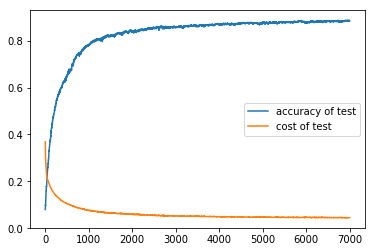

In [180]:
plt.plot(accuracy_momemtum, label = 'accuracy of test')
plt.plot(losses_momemtum, label = 'cost of test')
plt.legend()
plt.show()

In [182]:

learning_rate = 0.0001
reg = 0.01
mu = 0.90
dW1 = 0
db1 = 0
dW2 = 0
db2 = 0

W1 = W1_0 
b1 = b1_0 
W2 = W2_0 
b2 = b2_0 

N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

losses_momemtum = []
accuracy_momemtum = []

for i in range(1000):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        ybatch = ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
        pYbatch, hidden = forward(Xbatch, W1, b1, W2, b2)
 
        
        # gradient
        gW2 = derivative_w2(hidden, ybatch, pYbatch) + reg * W2 
        gb2 = derivative_b2(ybatch, pYbatch) + reg * b2
        gW1 = derivative_w1(Xbatch, hidden, ybatch, pYbatch, W2)+ reg * W1 
        gb1 = derivative_b1(ybatch, pYbatch, W2, hidden) + reg * b1 
        
        # update velocities
        dW2 = mu*dW2 + learning_rate * gW2
        db2 = mu*db2 + learning_rate * gb2
        dW1 = mu*dW1 + learning_rate * gW1
        db1 = mu*db1 + learning_rate * gb1
        
        # updates
        W2 += dW2
        b2 += db2
        W1 += dW1
        b1 += db1
        
        if j % 100 == 0:
            pY, _ = forward(Xtest, W1,b1, W2, b2)
            l = cross_entropy(ytest_ind, pY)
            losses_momemtum.append(l)
            print('cost at iteration i = %d, j = %d: %.6f' % (i,j,l))
            
            a = classification_rate(ytest, predict(pY))
            accuracy_momemtum.append(a)
            print('test clasification rate: ', a)
        
        
pYtrain, _ = forward(Xtrain, W1, b1, W2, b2)
pYtest, _ = forward(Xtest, W1, b1, W2, b2)
print('Final train classification_rate: ', classification_rate(ytrain, predict(pYtrain)))
print('Final test classification_rate: ', classification_rate(ytest, predict(pYtest)))

/Users/yucongweng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


cost at iteration i = 0, j = 0: 0.041779
test clasification rate:  0.886666666667
cost at iteration i = 1, j = 0: 0.042217
test clasification rate:  0.885595238095
cost at iteration i = 2, j = 0: 0.041837
test clasification rate:  0.886666666667
cost at iteration i = 3, j = 0: 0.041410
test clasification rate:  0.887380952381
cost at iteration i = 4, j = 0: 0.041641
test clasification rate:  0.886904761905
cost at iteration i = 5, j = 0: 0.041787
test clasification rate:  0.887738095238
cost at iteration i = 6, j = 0: 0.041966
test clasification rate:  0.887857142857
cost at iteration i = 7, j = 0: 0.041504
test clasification rate:  0.887261904762
cost at iteration i = 8, j = 0: 0.041232
test clasification rate:  0.891904761905
cost at iteration i = 9, j = 0: 0.040973
test clasification rate:  0.8925
cost at iteration i = 10, j = 0: 0.041564
test clasification rate:  0.889523809524
cost at iteration i = 11, j = 0: 0.040568
test clasification rate:  0.892142857143
cost at iteration i = 

cost at iteration i = 100, j = 0: 0.041392
test clasification rate:  0.887857142857
cost at iteration i = 101, j = 0: 0.043038
test clasification rate:  0.884642857143
cost at iteration i = 102, j = 0: 0.042747
test clasification rate:  0.887023809524
cost at iteration i = 103, j = 0: 0.041545
test clasification rate:  0.890119047619
cost at iteration i = 104, j = 0: 0.040961
test clasification rate:  0.893928571429
cost at iteration i = 105, j = 0: 0.040911
test clasification rate:  0.892976190476
cost at iteration i = 106, j = 0: 0.041654
test clasification rate:  0.889523809524
cost at iteration i = 107, j = 0: 0.042157
test clasification rate:  0.888333333333
cost at iteration i = 108, j = 0: 0.041464
test clasification rate:  0.891904761905
cost at iteration i = 109, j = 0: 0.041178
test clasification rate:  0.892976190476
cost at iteration i = 110, j = 0: 0.041360
test clasification rate:  0.894047619048
cost at iteration i = 111, j = 0: 0.041228
test clasification rate:  0.89285

cost at iteration i = 198, j = 0: 0.040497
test clasification rate:  0.893214285714
cost at iteration i = 199, j = 0: 0.040428
test clasification rate:  0.894523809524
cost at iteration i = 200, j = 0: 0.041254
test clasification rate:  0.895
cost at iteration i = 201, j = 0: 0.041280
test clasification rate:  0.894642857143
cost at iteration i = 202, j = 0: 0.041669
test clasification rate:  0.8925
cost at iteration i = 203, j = 0: 0.041304
test clasification rate:  0.89380952381
cost at iteration i = 204, j = 0: 0.041445
test clasification rate:  0.89369047619
cost at iteration i = 205, j = 0: 0.040672
test clasification rate:  0.893571428571
cost at iteration i = 206, j = 0: 0.040543
test clasification rate:  0.89380952381
cost at iteration i = 207, j = 0: 0.040597
test clasification rate:  0.89380952381
cost at iteration i = 208, j = 0: 0.040580
test clasification rate:  0.894047619048
cost at iteration i = 209, j = 0: 0.040489
test clasification rate:  0.89380952381
cost at iterat

cost at iteration i = 297, j = 0: 0.041340
test clasification rate:  0.890952380952
cost at iteration i = 298, j = 0: 0.041357
test clasification rate:  0.889047619048
cost at iteration i = 299, j = 0: 0.041384
test clasification rate:  0.888571428571
cost at iteration i = 300, j = 0: 0.041918
test clasification rate:  0.887023809524
cost at iteration i = 301, j = 0: 0.041981
test clasification rate:  0.887976190476
cost at iteration i = 302, j = 0: 0.041356
test clasification rate:  0.890357142857
cost at iteration i = 303, j = 0: 0.042220
test clasification rate:  0.886904761905
cost at iteration i = 304, j = 0: 0.042208
test clasification rate:  0.884047619048
cost at iteration i = 305, j = 0: 0.042082
test clasification rate:  0.889047619048
cost at iteration i = 306, j = 0: 0.041386
test clasification rate:  0.890357142857
cost at iteration i = 307, j = 0: 0.041278
test clasification rate:  0.891666666667
cost at iteration i = 308, j = 0: 0.041451
test clasification rate:  0.89047

cost at iteration i = 396, j = 0: 0.041024
test clasification rate:  0.890952380952
cost at iteration i = 397, j = 0: 0.040727
test clasification rate:  0.892023809524
cost at iteration i = 398, j = 0: 0.040663
test clasification rate:  0.890357142857
cost at iteration i = 399, j = 0: 0.040657
test clasification rate:  0.890476190476
cost at iteration i = 400, j = 0: 0.040619
test clasification rate:  0.890833333333
cost at iteration i = 401, j = 0: 0.040816
test clasification rate:  0.892380952381
cost at iteration i = 402, j = 0: 0.040574
test clasification rate:  0.8925
cost at iteration i = 403, j = 0: 0.040548
test clasification rate:  0.891666666667
cost at iteration i = 404, j = 0: 0.040789
test clasification rate:  0.890238095238
cost at iteration i = 405, j = 0: 0.040994
test clasification rate:  0.888571428571
cost at iteration i = 406, j = 0: 0.041129
test clasification rate:  0.889761904762
cost at iteration i = 407, j = 0: 0.040692
test clasification rate:  0.888452380952


cost at iteration i = 495, j = 0: 0.040215
test clasification rate:  0.895595238095
cost at iteration i = 496, j = 0: 0.039905
test clasification rate:  0.895952380952
cost at iteration i = 497, j = 0: 0.039916
test clasification rate:  0.896547619048
cost at iteration i = 498, j = 0: 0.039881
test clasification rate:  0.896785714286
cost at iteration i = 499, j = 0: 0.040156
test clasification rate:  0.897023809524
cost at iteration i = 500, j = 0: 0.040094
test clasification rate:  0.897619047619
cost at iteration i = 501, j = 0: 0.040064
test clasification rate:  0.896904761905
cost at iteration i = 502, j = 0: 0.040032
test clasification rate:  0.897142857143
cost at iteration i = 503, j = 0: 0.039958
test clasification rate:  0.896428571429
cost at iteration i = 504, j = 0: 0.040010
test clasification rate:  0.896428571429
cost at iteration i = 505, j = 0: 0.040089
test clasification rate:  0.896547619048
cost at iteration i = 506, j = 0: 0.040052
test clasification rate:  0.89642

cost at iteration i = 593, j = 0: 0.039120
test clasification rate:  0.899047619048
cost at iteration i = 594, j = 0: 0.039090
test clasification rate:  0.899047619048
cost at iteration i = 595, j = 0: 0.039248
test clasification rate:  0.899166666667
cost at iteration i = 596, j = 0: 0.039213
test clasification rate:  0.899285714286
cost at iteration i = 597, j = 0: 0.039230
test clasification rate:  0.899047619048
cost at iteration i = 598, j = 0: 0.039225
test clasification rate:  0.899166666667
cost at iteration i = 599, j = 0: 0.039264
test clasification rate:  0.898928571429
cost at iteration i = 600, j = 0: 0.039012
test clasification rate:  0.899523809524
cost at iteration i = 601, j = 0: 0.039081
test clasification rate:  0.899523809524
cost at iteration i = 602, j = 0: 0.039591
test clasification rate:  0.896666666667
cost at iteration i = 603, j = 0: 0.039283
test clasification rate:  0.896904761905
cost at iteration i = 604, j = 0: 0.040963
test clasification rate:  0.89166

cost at iteration i = 691, j = 0: 0.039831
test clasification rate:  0.896428571429
cost at iteration i = 692, j = 0: 0.039847
test clasification rate:  0.896428571429
cost at iteration i = 693, j = 0: 0.039862
test clasification rate:  0.895952380952
cost at iteration i = 694, j = 0: 0.039751
test clasification rate:  0.895833333333
cost at iteration i = 695, j = 0: 0.039741
test clasification rate:  0.895833333333
cost at iteration i = 696, j = 0: 0.039773
test clasification rate:  0.895952380952
cost at iteration i = 697, j = 0: 0.039763
test clasification rate:  0.895595238095
cost at iteration i = 698, j = 0: 0.039764
test clasification rate:  0.895595238095
cost at iteration i = 699, j = 0: 0.039760
test clasification rate:  0.895595238095
cost at iteration i = 700, j = 0: 0.039777
test clasification rate:  0.895357142857
cost at iteration i = 701, j = 0: 0.040009
test clasification rate:  0.893571428571
cost at iteration i = 702, j = 0: 0.039960
test clasification rate:  0.89369

cost at iteration i = 789, j = 0: 0.039798
test clasification rate:  0.89619047619
cost at iteration i = 790, j = 0: 0.039752
test clasification rate:  0.896666666667
cost at iteration i = 791, j = 0: 0.039642
test clasification rate:  0.897380952381
cost at iteration i = 792, j = 0: 0.039667
test clasification rate:  0.897023809524
cost at iteration i = 793, j = 0: 0.039690
test clasification rate:  0.897023809524
cost at iteration i = 794, j = 0: 0.039486
test clasification rate:  0.897619047619
cost at iteration i = 795, j = 0: 0.039549
test clasification rate:  0.897738095238
cost at iteration i = 796, j = 0: 0.039522
test clasification rate:  0.897380952381
cost at iteration i = 797, j = 0: 0.039734
test clasification rate:  0.896904761905
cost at iteration i = 798, j = 0: 0.039734
test clasification rate:  0.896785714286
cost at iteration i = 799, j = 0: 0.039750
test clasification rate:  0.896428571429
cost at iteration i = 800, j = 0: 0.039710
test clasification rate:  0.896547

cost at iteration i = 887, j = 0: 0.039836
test clasification rate:  0.894880952381
cost at iteration i = 888, j = 0: 0.039837
test clasification rate:  0.894880952381
cost at iteration i = 889, j = 0: 0.039662
test clasification rate:  0.89619047619
cost at iteration i = 890, j = 0: 0.039655
test clasification rate:  0.896904761905
cost at iteration i = 891, j = 0: 0.039681
test clasification rate:  0.896904761905
cost at iteration i = 892, j = 0: 0.039645
test clasification rate:  0.896785714286
cost at iteration i = 893, j = 0: 0.039663
test clasification rate:  0.896666666667
cost at iteration i = 894, j = 0: 0.039726
test clasification rate:  0.896428571429
cost at iteration i = 895, j = 0: 0.039721
test clasification rate:  0.896428571429
cost at iteration i = 896, j = 0: 0.039722
test clasification rate:  0.896428571429
cost at iteration i = 897, j = 0: 0.039720
test clasification rate:  0.896428571429
cost at iteration i = 898, j = 0: 0.039720
test clasification rate:  0.896428

cost at iteration i = 985, j = 0: 0.039664
test clasification rate:  0.896547619048
cost at iteration i = 986, j = 0: 0.039588
test clasification rate:  0.896666666667
cost at iteration i = 987, j = 0: 0.039646
test clasification rate:  0.896904761905
cost at iteration i = 988, j = 0: 0.039627
test clasification rate:  0.897023809524
cost at iteration i = 989, j = 0: 0.039654
test clasification rate:  0.896785714286
cost at iteration i = 990, j = 0: 0.039617
test clasification rate:  0.896785714286
cost at iteration i = 991, j = 0: 0.039764
test clasification rate:  0.896547619048
cost at iteration i = 992, j = 0: 0.039657
test clasification rate:  0.896904761905
cost at iteration i = 993, j = 0: 0.039662
test clasification rate:  0.896785714286
cost at iteration i = 994, j = 0: 0.039690
test clasification rate:  0.896785714286
cost at iteration i = 995, j = 0: 0.039692
test clasification rate:  0.896785714286
cost at iteration i = 996, j = 0: 0.039698
test clasification rate:  0.89690

In [183]:
pYtrain, _ = forward(Xtrain, W1, b1, W2, b2)
pYtest, _ = forward(Xtest, W1, b1, W2, b2)
print('Final train classification_rate: ', classification_rate(ytrain, predict(pYtrain)))
print('Final test classification_rate: ', classification_rate(ytest, predict(pYtest)))

Final train classification_rate:  0.902529761905
Final test classification_rate:  0.896904761905


/Users/yucongweng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


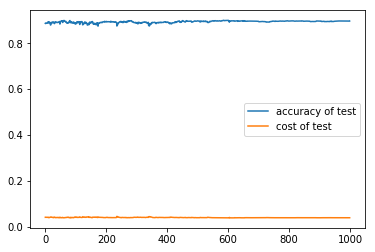

In [184]:
plt.plot(accuracy_momemtum, label = 'accuracy of test')
plt.plot(losses_momemtum, label = 'cost of test')
plt.legend()
plt.show()